## In this notebook load the data from cluster analysis and visualise them (maily figure 4 of manuscript).

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools2 as pf
import seaborn as sns
import pandas as pd
import mtools as mot
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:
fs = 20# sampling freq
dt = 1/fs  # bin size of each time index
dy = 0.001 # bin size for position histogram. Since we will smooth the histogram anyways, the smaller the better (approaching Kernel Density Estimation).
sigma_y = 0.05 # I do not know the size of the animal. So, assume it to be 1% of the track.
sigma_yidx = sigma_y/dy  # Convert the position unit to unit of array index.
yedges = np.arange(0-dy/2, 1+dy, dy)  # edges for histogram
y_ax = pf.MidAx(yedges)  # position axis, mainly for plotting. Since edges are just for histogram.
allfolders2=['478','481','483','485']

In [3]:
import configparser
import os

# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']


In [4]:
# In this code i load the data from outward runs and find the cells which are place cells.
#burst_len='200ms'
fol='478'
dir_of_run='L'
#celltype='PC'
celltype='Alltest_neworder'
fs = 20# sampling freq
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst

In [5]:
phase='learned'

In [6]:

def compute_allinfo(all_rates,P_x,r0,num_neurons):
    all_I_f = np.zeros(num_neurons)  # Forward I

    for nid in range(num_neurons):
  
        all_I_f[nid] = pf.computeSpatialInfo(all_rates[nid, :], P_x, r0[nid])
    return(all_I_f)

In [7]:
# get the data of all animals and compare the significant place Clusters of learning with learned. to see the effect of learning on pc statistics.

Compare_learning_learned_PC_cluster={'learning':{},'learned':{},'all':{}}
allfolders2=['478','481','483','485']
Rates_cluster={'learning':{},'learned':{},'all':{}}
Rates_sh_cluster={'learning':{},'learned':{},'all':{}}
Cluster_type={}
sig_cluster_id_all={'learning':{},'learned':{},'all':{}}
all_cluster_id_all={'learning':{},'learned':{},'all':{}}

Rates_cluster2={}
direction=['L','R']

phases=['learning','learned']

for phase in phases:
    rates_animal={}
    rates_sh_animal={}
    Cluster_types_all2={}
    cluster_rate_all_animals={}
    PC_fol_stats={}
    cluster_number_outward_anm={}
    sig_clstr_id1={}
    all_clstr_id1={}

    for fol1 in allfolders2:
        PC_dir_stats={}
        rate_dir={}
        rate_sh_dir={}
        sig_clstr_id2={}
        all_clstr_id2={}

        cluster_number_dir={}

        for dir in direction:
            #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
        
            data = np.load(savefolder+fol1+'Sesseion_info'+'_with_PC',allow_pickle=True)

            rate_dir[dir]=data['place_cluster_data'][phase][dir]['rate_all_clusters']
            rate_sh_dir[dir]=data['place_cluster_data'][phase][dir]['rate_shuffled_clusters']

            cluster_pc_fractions=data['place_cluster_data'][phase][dir]
            
            PC_dir_stats[dir]= cluster_pc_fractions['pvalues']<.05
            sig_clstr_id2[dir]=cluster_pc_fractions['singnificnts_cluster_ids']
            all_clstr_id2[dir]=cluster_pc_fractions['cluster_numbers']

            
            cluster_number_dir[dir]= cluster_pc_fractions['cluster_numbers']

        cluster_number_outward_anm[fol1]=(np.unique(np.concatenate((cluster_number_dir['L'] ,cluster_number_dir['R']))))

        PC_fol_stats[fol1]=PC_dir_stats
        sig_clstr_id1[fol1]=sig_clstr_id2
        all_clstr_id1[fol1]=all_clstr_id2


        cluster_pc_fractions_L=data['place_cluster_data'][phase]['L']
        cluster_pc_fractions_R=data['place_cluster_data'][phase]['R']    
        if (len(cluster_pc_fractions_L['rate_significant'])>0) & (len(cluster_pc_fractions_R['rate_all_clusters'])>0):



            rates_left_sig,rates_right_all,cluster_rate_all_animals_L= pf.equal_cluster_length(cluster_pc_fractions_L,cluster_pc_fractions_R)

            sort_idx_L=np.argsort(np.argmax(rates_left_sig,axis=1))
            sorted_l=np.asarray(rates_left_sig)[sort_idx_L]
            sorted_r=np.asarray(rates_right_all)[sort_idx_L]
            significant_cluster_idx_L= (cluster_pc_fractions_L['singnificnts_cluster_ids'] )
            #sig_idx_l_sorted=[x for x in significant_cluster_idx if x in sig_sort_idx_L]
            max_clstr=np.max(np.concatenate((cluster_pc_fractions_L['cluster_numbers'],cluster_pc_fractions_R['cluster_numbers'])))

            sig_idx_l_sorted = np.isin(sort_idx_L, significant_cluster_idx_L)# SI and sorted l

            #mask_op_run=np.sum(sorted_r,axis=1)>0# check if the opposite run exist
            #sig_idx_l_sorted=sig_idx_l_sorted & mask_op_run# only include clusters that are acive in both sides


            correlation_l_r,correlation_l_r_stem,similarity_between_l_and_r_all,mask_cut_l= pf.compute_corrleation(sorted_l,sorted_r)
            p_val_clusters_l,mask_cut_l = pf.shuffling_cluster_rates_new(sorted_l,sorted_r,cluster_pc_fractions_L,cluster_pc_fractions_R,sort_idx_L)


            mask_corr_l=p_val_clusters_l<0.05

            tc_arm_clstr_l= sig_idx_l_sorted & mask_cut_l & mask_corr_l
            pc_arm_clstr_l= sig_idx_l_sorted & mask_cut_l & ~mask_corr_l
            tc_stem_clstr_l= sig_idx_l_sorted & ~mask_cut_l & mask_corr_l
            pc_stem_clstr_l= sig_idx_l_sorted & ~mask_cut_l & ~mask_corr_l

            # tc_arm_clstr_l=   mask_cut_l & mask_corr_l
            # pc_arm_clstr_l=  mask_cut_l & ~mask_corr_l
            # tc_stem_clstr_l=  ~mask_cut_l & mask_corr_l
            # pc_stem_clstr_l=  ~mask_cut_l & ~mask_corr_l







            rates_right_sig,rates_left_all,cluster_rate_all_animals_R= pf.equal_cluster_length(cluster_pc_fractions_R,cluster_pc_fractions_L)

            sort_idx_R=np.argsort(np.argmax(rates_right_sig,axis=1))
            sorted_r=np.asarray(rates_right_sig)[sort_idx_R]
            sorted_l=np.asarray(rates_left_all)[sort_idx_R]
            significant_cluster_idx_R= (cluster_pc_fractions_R['singnificnts_cluster_ids'] )
            #sig_idx_l_sorted=[x for x in significant_cluster_idx if x in sig_sort_idx_L]
            #max_clstr=np.max(np.concatenate((cluster_pc_fractions_R['cluster_numbers'],cluster_pc_fractions_L['cluster_numbers'])))

            sig_idx_r_sorted = np.isin(sort_idx_R, significant_cluster_idx_R)# SI and sorted l
            #mask_op_run=np.sum(sorted_l,axis=1)>0# check if the opposite run exist
            #sig_idx_r_sorted=sig_idx_r_sorted & mask_op_run# only include clusters that are acive in both sides


            correlation_r_l,correlation_r_l_stem,similarity_between_r_and_r_all,mask_cut_r= pf.compute_corrleation(sorted_r,sorted_l)
            p_val_clusters_r,mask_cut_r = pf.shuffling_cluster_rates_new(sorted_r,sorted_l,cluster_pc_fractions_R,cluster_pc_fractions_L,sort_idx_R)


            mask_corr_r=p_val_clusters_r<0.05

            tc_arm_clstr_r= sig_idx_r_sorted & mask_cut_r & mask_corr_r
            pc_arm_clstr_r= sig_idx_r_sorted & mask_cut_r & ~mask_corr_r
            tc_stem_clstr_r= sig_idx_r_sorted & ~mask_cut_r & mask_corr_r
            pc_stem_clstr_r= sig_idx_r_sorted & ~mask_cut_r & ~mask_corr_r


            # tc_arm_clstr_r=  mask_cut_r & mask_corr_r
            # pc_arm_clstr_r=  mask_cut_r & ~mask_corr_r
            # tc_stem_clstr_r=  ~mask_cut_r & mask_corr_r
            # pc_stem_clstr_r=  ~mask_cut_r & ~mask_corr_r





            place_cell_vs_target_cell={}
            Cluster_types_rate={}

            Cluster_types_rate['TC_arm']=np.union1d(sort_idx_L[tc_arm_clstr_l],sort_idx_R[tc_arm_clstr_r])
            Cluster_types_rate['PC_arm']=np.union1d(sort_idx_L[pc_arm_clstr_l],sort_idx_R[pc_arm_clstr_r])
            Cluster_types_rate['TC_stem']=np.union1d(sort_idx_L[tc_stem_clstr_l],sort_idx_R[tc_stem_clstr_r])
            Cluster_types_rate['PC_stem']=np.union1d(sort_idx_L[pc_stem_clstr_l],sort_idx_R[pc_stem_clstr_r])


            # Cluster_types_rate['TC_arm']=sort_idx_R[tc_arm_clstr_r]
            # Cluster_types_rate['PC_arm']=sort_idx_R[pc_arm_clstr_r]
            # Cluster_types_rate['TC_stem']=sort_idx_R[tc_stem_clstr_r]
            # Cluster_types_rate['PC_stem']=sort_idx_R[pc_stem_clstr_r]



            Cluster_types_all2[fol1]=Cluster_types_rate
            cluster_rate_all_animals[fol1]=cluster_rate_all_animals_L# Temporary

        else:

            Cluster_types_rate={}

            Cluster_types_rate['TC_arm']=[]
            Cluster_types_rate['PC_arm']=[]

            Cluster_types_rate['TC_stem']=[]
            Cluster_types_rate['PC_stem']=[]
            Cluster_types_all2[fol1]=Cluster_types_rate


        rates_animal[fol1]=rate_dir
        rates_sh_animal[fol1]=rate_sh_dir

    Cluster_type[phase]=Cluster_types_all2
    Rates_cluster[phase]=rates_animal
    Rates_sh_cluster[phase]=rates_sh_animal

    Rates_cluster2[phase]=cluster_rate_all_animals

    sig_cluster_id_all[phase]=sig_clstr_id1
    all_cluster_id_all[phase]=all_clstr_id1

    Compare_learning_learned_PC_cluster[phase]=PC_fol_stats# Masks of SI cells

c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [8]:
import pickle
with open(savefolder+'_Cluster_types', 'wb') as file:
    pickle.dump(Cluster_type, file)

C:\Users\hamed\AppData\Local\Temp\ipykernel_15980\3086784038.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  al_clstrs[typeofcelss] = np.array([np.array(sublist) for sublist in al_clstrs[typeofcelss]])
C:\Users\hamed\AppData\Local\Temp\ipykernel_15980\3086784038.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  al_clstrs_r[typeofcelss] = np.array([np.array(sublist) for sublist in al_clstrs_r[typeofcelss]])


Text(0.5, 0.98, 'PC_arm')

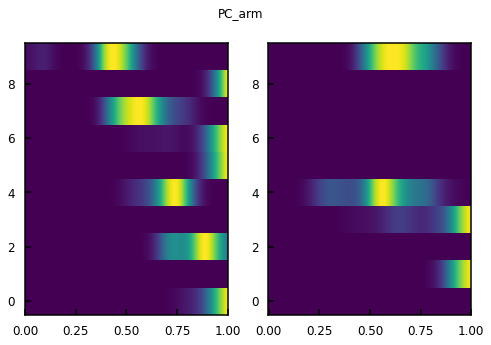

In [9]:
typeofcelss='PC_arm'
al_clstrs={typeofcelss:[]}
al_clstrs_r={typeofcelss:[]}

for anm in allfolders2:
    clstr_rates= Rates_cluster2['learned'][anm]['R'][Cluster_type['learned'][anm][typeofcelss]]
    al_clstrs[typeofcelss].append(clstr_rates)

    clstr_rates= Rates_cluster2['learned'][anm]['L'][Cluster_type['learned'][anm][typeofcelss]]
    al_clstrs_r[typeofcelss].append(clstr_rates)

# Convert to a NumPy array and flatten into a 2D matrix
al_clstrs[typeofcelss] = np.array([np.array(sublist) for sublist in al_clstrs[typeofcelss]])
flattened_matrix = np.vstack(al_clstrs[typeofcelss])

# Convert to a NumPy array and flatten into a 2D matrix
al_clstrs_r[typeofcelss] = np.array([np.array(sublist) for sublist in al_clstrs_r[typeofcelss]])
flattened_matrix_r = np.vstack(al_clstrs_r[typeofcelss])


ig, (ax,ax2) = plt.subplots(1, 2,figsize=(8, 5))

# im = ax.pcolormesh(y_ax, np.arange(np.shape(left_runs[~mask_cut & ~mask_corr])[0]), left_runs[sig_sort_idx][~mask_cut & ~mask_corr]/np.max(np.asarray(left_runs)[sig_sort_idx][~mask_cut & ~mask_corr],axis=1)[:, np.newaxis],
#                    rasterized=True)
# Replace NaN with zero before normalization
cleaned_data = flattened_matrix

# Normalize the data row-wise, handling cases where the max value is zero
max_values = np.max(cleaned_data, axis=1, keepdims=True)
normalized_data = np.divide(
    cleaned_data,
    max_values,
    out=np.zeros_like(cleaned_data),  # Fill with zeros where division is invalid
    where=max_values > 0  # Only divide where max_values > 0
)

# Plot the cleaned and normalized data
im = ax.pcolormesh(
    y_ax,
    np.arange(np.shape(normalized_data)[0]),
    normalized_data,
    rasterized=True,
    cmap='viridis'
)


#flattened_matrix_r = np.vstack(al_clstrs_r[typeofcelss])

cleaned_data = flattened_matrix_r
max_values = np.max(cleaned_data, axis=1, keepdims=True)

normalized_data = np.divide(
    cleaned_data,
    max_values,
    out=np.zeros_like(cleaned_data),  # Fill with zeros where division is invalid
    where=max_values > 0  # Only divide where max_values > 0)
)
im = ax2.pcolormesh(
    y_ax,
    np.arange(np.shape(normalized_data)[0]),
    normalized_data,
    rasterized=True,
    cmap='viridis')

plt.suptitle(typeofcelss)


In [10]:
Compare_learning_learned_PC_cluster_adjusted={'learning':{},'learned':{},'all':{}}
cluster_change=pf.compare_clusters(sig_cluster_id_all['learning'], sig_cluster_id_all['learned'])
cluster_change_types = pf.compare_phases(Cluster_type['learning'], Cluster_type['learned'])

PC_fol_stats_learning={}
PC_fol_stats_leared={}
ratio_sig_to_all_clusters_learning={}
ratio_sig_to_all_clusters_learned={}

Cluster_transition_Nonsig_to_sig={}
Cluster_transition_Sig_to_Nonsig={}

Cluster_transition={'Sig_to_Nonsig':{},'Nonsig_to_sig':{}}
Cluster_transition_types={'Sig_to_Nonsig':{},'Nonsig_to_sig':{}}
Nonsig_to_sig_type={}# c
Sig_to_nonsig_type={}


binary_idx_anm_learning={}
binary_idx_anm_learned={}

rate_anm_learning={}
rate_anm_learned={}

rate_sh_anm_learning={}
rate_sh_anm_learned={}

Binary_idx={}
Cluster_rate={}
Cluster_rate_sh={}

shuffle_nbr=len(Rates_sh_cluster['learned']['478']['L'])# number of shuffles is equal for all animals

rate_len=np.shape(Rates_cluster['learning']['478']['L'])[1]# rate of all animals have the same length


for fol1 in allfolders2:
    PC_dir_stats={}
    sig_clstr_id2={}

    PC_dir_stats_learning={}
    PC_dir_stats_learned={}

    #total_cluster_outward=len(cluster_number_outward['all'][fol1])# total cluster numbers of outwrad run for this animal
    #max_clstr=np.max(cluster_number_outward['all'][fol1])+1# total cluster numbers of outwrad run for this animal



    # filename = fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients'
    # data_animal2 = np.load(join(savefolder, filename), allow_pickle=True)# Templates of clusterd data
    data_animal2 = np.load(savefolder+fol1+'Sesseion_info'+'_with_PC',allow_pickle=True)



    max_clstr=np.max(data_animal2['sess_info']['ids_clust'])+1# if you want to consider the whol session as total cluster number


    ratio_ed={}
    ratio_ing={}

    Nonsig_to_sig={}# c
    Sig_to_nonsig={}




    bin_index_learned={}
    bin_index_learning={}

    rate_dir_learned={}
    rate_dir_learning={}


    rate_sh_dir_learning={}
    rate_sh_dir_learned={}
    for dir in direction:


        #max_clstr=int(np.max(np.concatenate((sig_cluster_id_all['learning'][fol1][dir],sig_cluster_id_all['learned'][fol1][dir])))+1)
        clstr_idx_learning=np.zeros(max_clstr).astype(bool)
        clstr_idx_learned=np.zeros(max_clstr).astype(bool)



        clstr_rate_learning=np.zeros([max_clstr,rate_len])
        clstr_rate_learned=np.zeros([max_clstr,rate_len])

        clstr_rate_sh_learning=np.zeros([shuffle_nbr,max_clstr,rate_len])
        clstr_rate_sh_learned=np.zeros([shuffle_nbr,max_clstr,rate_len])



        if len(sig_cluster_id_all['learning'][fol1][dir])>0:

            clstr_idx_learning[sig_cluster_id_all['learning'][fol1][dir]]=True
            ratio_ing[dir]=len(sig_cluster_id_all['learning'][fol1][dir])/max_clstr
            clstr_rate_learning[all_cluster_id_all['learning'][fol1][dir]]=Rates_cluster['learning'][fol1][dir]
            for sh in range(shuffle_nbr):
                clstr_rate_sh_learning[sh][all_cluster_id_all['learning'][fol1][dir]]=Rates_sh_cluster['learning'][fol1][dir][sh]




        clstr_idx_learned[sig_cluster_id_all['learned'][fol1][dir]]=True
        ratio_ed[dir]=len(sig_cluster_id_all['learned'][fol1][dir])/max_clstr
        clstr_rate_learned[all_cluster_id_all['learned'][fol1][dir]]=Rates_cluster['learned'][fol1][dir]
        for sh in range(shuffle_nbr):
            clstr_rate_sh_learned[sh][all_cluster_id_all['learned'][fol1][dir]]=Rates_sh_cluster['learned'][fol1][dir][sh]




        sig_clusters=len(np.concatenate((sig_cluster_id_all['learned'][fol1][dir],sig_cluster_id_all['learning'][fol1][dir])))
        if sig_clusters==0:
            sig_clusters=1
        Sig_to_nonsig[dir]=len(cluster_change[fol1][dir]['not_in_learned'])/sig_clusters# % clusters where signifciant in learning but not in learned
        Nonsig_to_sig[dir]=len(cluster_change[fol1][dir]['not_in_learning'])/sig_clusters# % clusters where signifciant in learned but not in learning


        bin_index_learning[dir]=clstr_idx_learning
        bin_index_learned[dir]=clstr_idx_learned


        rate_dir_learning[dir]=clstr_rate_learning
        rate_dir_learned[dir]=clstr_rate_learned

        rate_sh_dir_learning[dir]=clstr_rate_sh_learning
        rate_sh_dir_learned[dir]=clstr_rate_sh_learned



        PC_dir_stats_learning[dir]=clstr_idx_learning
        PC_dir_stats_learned[dir]=clstr_idx_learning

    PC_fol_stats_learning[fol1]=PC_dir_stats_learning
    PC_fol_stats_leared[fol1]=PC_dir_stats_learned

    ratio_sig_to_all_clusters_learned[fol1]=ratio_ed
    ratio_sig_to_all_clusters_learning[fol1]=ratio_ing


    Cluster_transition_Sig_to_Nonsig[fol1]=Sig_to_nonsig
    Cluster_transition_Nonsig_to_sig[fol1]=Nonsig_to_sig


    type_changes_non_to_sig={}
    type_changes_sig_to_non={}
    for ctype in cluster_change_types[fol1].keys():
        type_changes_non_to_sig[ctype]=len(cluster_change_types[fol1][ctype]['not_in_learning'])/sig_clusters
        type_changes_sig_to_non[ctype]=len(cluster_change_types[fol1][ctype]['not_in_learned'])/sig_clusters
    Nonsig_to_sig_type[fol1]=type_changes_non_to_sig
    Sig_to_nonsig_type[fol1]=type_changes_sig_to_non

    binary_idx_anm_learned[fol1]=bin_index_learned
    binary_idx_anm_learning[fol1]=bin_index_learning

    rate_anm_learning[fol1]=rate_dir_learning
    rate_anm_learned[fol1]=rate_dir_learned


    rate_sh_anm_learning[fol1]=rate_sh_dir_learning
    rate_sh_anm_learned[fol1]=rate_sh_dir_learned

Compare_learning_learned_PC_cluster_adjusted['learning']=PC_fol_stats_learning
Compare_learning_learned_PC_cluster_adjusted['learned']=PC_fol_stats_leared
Cluster_transition['Sig_to_Nonsig']=Cluster_transition_Sig_to_Nonsig# ratio of change in cluster significance after learning
Cluster_transition['Nonsig_to_sig']=Cluster_transition_Nonsig_to_sig


Cluster_transition_types['Sig_to_Nonsig']=Sig_to_nonsig_type# ratio of change in cluster significance after learning
Cluster_transition_types['Nonsig_to_sig']=Nonsig_to_sig_type

Binary_idx['learning']=binary_idx_anm_learning
Binary_idx['learned']=binary_idx_anm_learned


Cluster_rate['learning']=rate_anm_learning
Cluster_rate['learned']=rate_anm_learned


Cluster_rate_sh['learning']=rate_sh_anm_learning
Cluster_rate_sh['learned']=rate_sh_anm_learned

In [11]:

# left_rates=[Cluster_rate['learning'][x]['L']  for x in Cluster_rate['learned'].keys()]
# #left_rates=Cluster_rate['learned']['478']['L']
# merged_matrix_left = np.vstack(left_rates)


# right_rates=[Cluster_rate['learned'][x]['L']  for x in Cluster_rate['learned'].keys()]
# #right_rates=Cluster_rate['learned']['478']['R']

# merged_matrix_right = np.vstack(right_rates)
# # Filter and merge arrays ending with '_L'
# merged_data_L= merged_matrix_left#= np.vstack([arr for key, arr in PC_frac_L_R_clusters_Rates.items() if key.endswith('_L') and arr.size > 0])

# # Filter and merge arrays ending with '_R'
# merged_data_R =merged_matrix_right#= np.vstack([arr for key, arr in PC_frac_L_R_clusters_Rates.items() if key.endswith('_R') and arr.size > 0])

# # Convert the merged NumPy arrays to lists if needed
# merged_list_L = np.asarray(merged_data_L.tolist())
# merged_list_R = np.asarray(merged_data_R.tolist())


# sig_sort_idx_L=np.argsort(np.argmax(merged_list_L,axis=1))
# sig_sort_idx_R=np.argsort(np.argmax(merged_list_R,axis=1))


# # Normalize each row safely for merged_list_L
# row_max_L = np.max(merged_list_L, axis=1, keepdims=True)
# merged_list_L = np.where(row_max_L != 0, merged_list_L / row_max_L, 0)

# # Normalize each row safely for merged_list_R
# row_max_R = np.max(merged_list_R, axis=1, keepdims=True)
# merged_list_R = np.where(row_max_R != 0, merged_list_R / row_max_R, 0)


# fig, (ax,ax2) = plt.subplots(1, 2,figsize=(16, 8))

# im = ax.pcolormesh(y_ax, np.arange(len(sig_sort_idx_L)), merged_list_L[sig_sort_idx_L,:])
# #ax.set_yticks(np.arange(np.sum(sign)))
# #ax.set_yticklabels(merged_list[sig_sort_idx])
# plt.colorbar(im, ax=ax)
# plt.subplot(122)
# ax.set_title('Left run cluster pf all animals ')
# ax.set_ylabel('Cluster #')
# ax.set_xlabel('Position')
# im = ax2.pcolormesh(y_ax, np.arange(len(sig_sort_idx_L)), merged_list_R[sig_sort_idx_L,:])
# #ax2.set_yticks(np.arange(len(sig_sort_idx_R)))
# #ax2.set_yticklabels(merged_list[sig_sort_idx])
# plt.colorbar(im, ax=ax2)
# ax2.set_title('Right run cluster pf merged all animals')

# ax.set_xlabel('Position')


In [12]:
cluster_type_ratios,ratios_sig_cluster,PC_to_nonPC_cluster=pf.calculate_common_ratio(Binary_idx)


In [13]:
# PC transitions. Calculate averages over all animals
SI_to_nonSI_cluster_avg = {side: {key: sum(sample[side][key] for sample in PC_to_nonPC_cluster.values()) / len(PC_to_nonPC_cluster) 
              for key in ['NonPC_to_PC', 'PC_NonPC']} for side in ['L', 'R']}

# Difference Between Learned and Learning Ratios. Calculate averages over all animals
ratios_sig_cluster_avg = {state: {side: sum(sample[state][side] for sample in ratios_sig_cluster.values()) / len(ratios_sig_cluster)
                      for side in ['L', 'R']} for state in ['learning', 'learned']}



# Common significants. 
cluster_type_ratios_avg = {side: sum(sample[side] for sample in cluster_type_ratios.values()) / len(cluster_type_ratios) 
                      for side in ['L', 'R']}

In [14]:
# from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

# # Extract data for each state and side
# learning_L = [ratios_sig_cluster[animal]['learning']['L'] for animal in ratios_sig_cluster]
# learned_L = [ratios_sig_cluster[animal]['learned']['L'] for animal in ratios_sig_cluster]

# learning_R = [ratios_sig_cluster[animal]['learning']['R'] for animal in ratios_sig_cluster]
# learned_R = [ratios_sig_cluster[animal]['learned']['R'] for animal in ratios_sig_cluster]

# # Perform paired t-tests
# # t_stat_L, p_value_L = ttest_rel(learning_L, learned_L)
# # t_stat_R, p_value_R = ttest_rel(learning_R, learned_R)


# stat_L, p_value_L = wilcoxon(learning_L, learned_L, alternative='two-sided')
# stat_R, p_value_R = wilcoxon(learning_R, learned_R, alternative='two-sided')


c:\Users\hamed\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\hamed\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


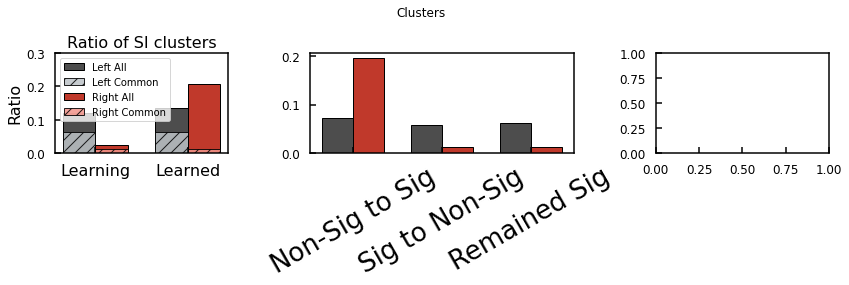

In [15]:
# Merge "learning L" and "learning R" into a single list
learning_merged = [ratios_sig_cluster[animal]['learning']['L'] for animal in ratios_sig_cluster] + \
                  [ratios_sig_cluster[animal]['learning']['R'] for animal in ratios_sig_cluster]

# Merge "learned L" and "learned R" into a single list
learned_merged = [ratios_sig_cluster[animal]['learned']['L'] for animal in ratios_sig_cluster] + \
                 [ratios_sig_cluster[animal]['learned']['R'] for animal in ratios_sig_cluster]

# Perform Wilcoxon Signed-Rank Test on the merged values
stat_merged, p_value_merged = wilcoxon(learning_merged, learned_merged, alternative='two-sided')


fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1,1.52,1 ]})

# Colors and properties for the bars
# colors = ['#69b3a2', '#e74c3c']
# colors = ['#FF7F50', '#4682B4']

colors = ['#4D4D4D', '#C0392B']
colors2 = ['#BDC3C7', '#F1948A']
learning_categories = ['Learning', 'Learned']
learning_L = [ratios_sig_cluster_avg['learning']['L'], ratios_sig_cluster_avg['learned']['L']]
learning_R = [ratios_sig_cluster_avg['learning']['R'], ratios_sig_cluster_avg['learned']['R']]

x = np.arange(len(learning_categories))  # the label locations
width = 0.35  # the width of the bars

axes[0].bar(x - width/2, learning_L, width, label='Left All', color=colors[0], edgecolor='black',alpha=1)
axes[0].bar(x - width/2, cluster_type_ratios_avg['L'], width, label='Left Common', color=colors2[0], edgecolor='black',alpha=.855, hatch='//')

axes[0].bar(x + width/2, learning_R, width, label='Right All', color=colors[1], edgecolor='black',alpha=1)
axes[0].bar(x + width/2, cluster_type_ratios_avg['R'], width, label='Right Common', color=colors2[1], edgecolor='black',alpha=.855, hatch='//')


#axes[0].bar(x - width/2, np.array(learning_L)*100, width, label='Left', color=colors[0], edgecolor='black')
#axes[0].bar(x + width/2, np.array(learning_R)*100, width, label='Right', color=colors[1], edgecolor='black')
axes[0].set_title('Ratio of SI clusters', fontsize=16)
axes[0].set_ylabel('Ratio', fontsize=16)
axes[0].set_xticks(x)
axes[0].set_xticklabels(learning_categories, fontsize=16)
#axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[0].legend(loc='upper left',fontsize=10)
# Adding significance star
# Assuming p-value is significant (e.g., p < 0.05)
significance_threshold = 0.05


if p_value_merged < significance_threshold:
    # Calculate the y-coordinate for the star
    y_max = max(max(learning_L), max(learning_R))
    y_star = y_max + 0.02  # Add some space above the highest bar
    line_length = 0.01  # Length of vertical lines

    # Add horizontal line and vertical ticks at ends
    axes[0].plot([x[0], x[1]], [y_star, y_star], color='black', linewidth=1.5)  # Horizontal line
    axes[0].plot([x[0], x[0]], [y_star - line_length, y_star], color='black', linewidth=1.5)  # Left tick
    axes[0].plot([x[1], x[1]], [y_star - line_length, y_star], color='black', linewidth=1.5)  # Right tick

    # Add a star at the middle
    axes[0].annotate('*', xy=(x.mean(), y_star + 0.005), ha='center', fontsize=20, color='black')
axes[0].set_ylim([0,.3])

# Bar plot for SI_to_nonSI_cluster_avg with corrected x labels
SI_to_nonSI_categories = ['Non-Sig to Sig', 'Sig to Non-Sig','Remained Sig']
SI_L = [SI_to_nonSI_cluster_avg['L']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['L']['PC_NonPC'],cluster_type_ratios_avg['L']]
SI_R = [SI_to_nonSI_cluster_avg['R']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['R']['PC_NonPC'],cluster_type_ratios_avg['R']]

# SI_L = [SI_to_nonSI_cluster_avg['L']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['L']['PC_NonPC'],cluster_type_ratios_avg['L']]
# SI_R = [SI_to_nonSI_cluster_avg['R']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['R']['PC_NonPC'],cluster_type_ratios_avg['R']]



x = np.arange(len(SI_to_nonSI_categories))  # the label locations

axes[1].bar(x - width/2, SI_L, width, label='Left', color=colors[0], edgecolor='black')
axes[1].bar(x + width/2, SI_R, width, label='Right', color=colors[1], edgecolor='black')
#axes[1].set_title('Transition in SI', fontsize=16)
#axes[2].set_ylabel('Average (%)', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(SI_to_nonSI_categories,rotation=30, fontsize=26)
#axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
#axes[1].legend(loc='upper right')

# Convert y-axis to percentage
#axes[1].set_yticklabels([f'{int(t*100)}%' for t in axes[1].get_yticks()])
plt.suptitle('Clusters')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig(savefolder+'Cluster_ratio.svg', format='svg',dpi=300)

plt.show()


In [16]:
p_value_merged

0.07473549830588248

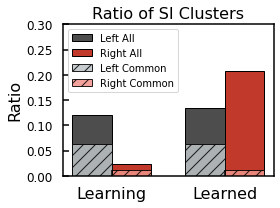

In [17]:
# Ratio of SI clusters

fig, ax = plt.subplots(1, 1, figsize=(4, 3))  # Single subplot

# Bar colors and properties
colors = ['#4D4D4D', '#C0392B']
colors2 = ['#BDC3C7', '#F1948A']
learning_categories = ['Learning', 'Learned']
learning_L = [ratios_sig_cluster_avg['learning']['L'], ratios_sig_cluster_avg['learned']['L']]
learning_R = [ratios_sig_cluster_avg['learning']['R'], ratios_sig_cluster_avg['learned']['R']]

x = np.arange(len(learning_categories))  # Label locations
width = 0.35  # Width of the bars

# Plot bars
ax.bar(x - width / 2, learning_L, width, label='Left All', color=colors[0], edgecolor='black', alpha=1)


ax.bar(x + width / 2, learning_R, width, label='Right All', color=colors[1], edgecolor='black', alpha=1)

ax.bar(x - width/2, cluster_type_ratios_avg['L'], width, label='Left Common', color=colors2[0], edgecolor='black',alpha=.855, hatch='//')

ax.bar(x + width/2, cluster_type_ratios_avg['R'], width, label='Right Common', color=colors2[1], edgecolor='black',alpha=.855, hatch='//')

# Titles, labels, and legend
ax.set_title('Ratio of SI Clusters', fontsize=16)
ax.set_ylabel('Ratio', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(learning_categories, fontsize=16)
ax.legend(loc='upper left', fontsize=10)

# Adding significance star
# Assuming p-value is significant (e.g., p < 0.05)
significance_threshold = 0.05
#p_value_merged = 0.028  # Example p-value

if p_value_merged < significance_threshold:
    # Calculate the y-coordinate for the star
    y_max = max(max(learning_L), max(learning_R))
    y_star = y_max + 0.02  # Add some space above the highest bar
    line_length = 0.01  # Length of vertical lines

    # Add horizontal line and vertical ticks at ends
    ax.plot([x[0], x[1]], [y_star, y_star], color='black', linewidth=1.5)  # Horizontal line
    ax.plot([x[0], x[0]], [y_star - line_length, y_star], color='black', linewidth=1.5)  # Left tick
    ax.plot([x[1], x[1]], [y_star - line_length, y_star], color='black', linewidth=1.5)  # Right tick

    # Add a star at the middle
    ax.annotate('*', xy=(x.mean(), y_star + 0.005), ha='center', fontsize=20, color='black')

# Adjust y-axis limits for better visibility
ax.set_ylim([0, 0.3])

plt.tight_layout()
plt.show()


In [18]:
# Get index of cluster types (TC/PC)
cluster_type_mask_phases={}
for ph in Binary_idx.keys():

    cell_type_mask={}
    for fol in Cluster_type[ph].keys():
        cell_type_mask_fol={}

        for type_indx in Cluster_type[ph][fol].keys():
            mask = np.zeros_like(Binary_idx[ph][fol]['R'])

            mask[Cluster_type[ph][fol][type_indx]]=True
            cell_type_mask_fol[type_indx]=mask
            #cell_type_mask[fol]={type_indx:mask}
        cell_type_mask[fol]=    cell_type_mask_fol
    cluster_type_mask_phases[ph]=cell_type_mask

In [19]:
[np.sum(cluster_type_mask_phases['learned']['485'][x]) for x in cluster_type_mask_phases['learned']['483'].keys()]

[1, 3, 0, 0]

In [20]:
# Evaluate the identity of PCs that became non_PC after learning - Clusters
PC_Transitions_cluster = {animal: {} for animal in allfolders2}
PC_Transitions2 = {animal: {} for animal in allfolders2}
PC_ratios_cluster = {animal: {} for animal in allfolders2}
PC_to_TC_ratios_cluster = {animal: {} for animal in allfolders2}
PC_Stability = {animal: {} for animal in allfolders2}

def safe_divide(numerator, denominator):
    return numerator / denominator if denominator > 0 else 0

for animal in allfolders2:
    PC_learning = cluster_type_mask_phases['learning'][animal]['PC_arm'] | cluster_type_mask_phases['learning'][animal]['PC_stem']
    PC_learned = cluster_type_mask_phases['learned'][animal]['PC_arm'] | cluster_type_mask_phases['learned'][animal]['PC_stem']
    PC_to_Non_PC = PC_learning & ~PC_learned  # PCs that became non_PC

    print(safe_divide(np.sum(PC_to_Non_PC), len(PC_to_Non_PC)))

    TC_learning = cluster_type_mask_phases['learning'][animal]['TC_arm'] | cluster_type_mask_phases['learning'][animal]['TC_stem']
    TC_learned = cluster_type_mask_phases['learned'][animal]['TC_arm'] | cluster_type_mask_phases['learned'][animal]['TC_stem']
    TC_to_Non_TC = TC_learning & ~TC_learned
    Non_TC_to_TC = ~TC_learning & TC_learned
    TC_to_TC = TC_learning & TC_learned
    TC_to_PC = TC_learning & PC_learned

    non_si_learning = ~(PC_learning | TC_learning)
    non_si_learned = ~(PC_learned | TC_learned)
    TC_to_Non_SI = TC_learning & non_si_learned

    Non_SI_learning = ~PC_learning & ~TC_learning
    Non_si_became_TC = non_si_learning & TC_learned
    SI_learned = TC_learned | PC_learned

    PC_to_TC = PC_learning & TC_learned
    PC_to_Non_PC_arm = cluster_type_mask_phases['learning'][animal]['PC_arm'] & ~cluster_type_mask_phases['learned'][animal]['PC_arm']
    PC_to_Non_PC_stem = cluster_type_mask_phases['learning'][animal]['PC_stem'] & ~cluster_type_mask_phases['learned'][animal]['PC_stem']

    # PC_Transitions_cluster calculations
    PC_Transitions_cluster[animal]['PC_arm_became_TC_arm'] = safe_divide(
        np.sum(cluster_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_arm),
        np.sum(TC_learned)
    )
    PC_Transitions_cluster[animal]['PC_arm_became_TC_stem'] = safe_divide(
        np.sum(cluster_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_arm),
        np.sum(TC_learned)
    )
    PC_Transitions_cluster[animal]['PC_stem_became_TC_stem'] = safe_divide(
        np.sum(cluster_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_stem),
        np.sum(TC_learned)
    )
    PC_Transitions_cluster[animal]['PC_stem_became_TC_arm'] = safe_divide(
        np.sum(cluster_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_stem),
        np.sum(TC_learned)
    )

    # PC_Transitions2 calculations
    PC_Transitions2[animal]['PC_arm_became_TC_arm'] = safe_divide(
        np.sum(cluster_type_mask_phases['learning'][animal]['PC_arm'] & cluster_type_mask_phases['learned'][animal]['TC_arm']),
        np.sum(TC_learned)
    )
    PC_Transitions2[animal]['PC_arm_became_TC_stem'] = safe_divide(
        np.sum(cluster_type_mask_phases['learning'][animal]['PC_arm'] & cluster_type_mask_phases['learned'][animal]['TC_stem']),
        np.sum(TC_learned)
    )
    PC_Transitions2[animal]['PC_stem_became_TC_stem'] = safe_divide(
        np.sum(cluster_type_mask_phases['learning'][animal]['PC_stem'] & cluster_type_mask_phases['learned'][animal]['TC_stem']),
        np.sum(TC_learned)
    )
    PC_Transitions2[animal]['PC_stem_became_TC_arm'] = safe_divide(
        np.sum(cluster_type_mask_phases['learning'][animal]['PC_stem'] & cluster_type_mask_phases['learned'][animal]['TC_arm']),
        np.sum(TC_learned)
    )

    # PC_ratios_cluster calculations
    PC_ratios_cluster[animal]['remained_pc'] = safe_divide(
        np.sum(PC_learning & PC_learned), np.sum(PC_learning)
    )
    PC_ratios_cluster[animal]['became_tc'] = safe_divide(
        np.sum(PC_learning & ~PC_learned & TC_learned), np.sum(PC_learning)
    )
    PC_ratios_cluster[animal]['pc_learning'] = safe_divide(
        np.sum(PC_learning), len(PC_learning)
    )
    PC_ratios_cluster[animal]['non_si_became_tc'] = safe_divide(
        np.sum(Non_si_became_TC), np.sum(TC_learned)
    )
    PC_ratios_cluster[animal]['non_tc_became_tc'] = safe_divide(
        np.sum(Non_TC_to_TC), np.sum(TC_learned)
    )
    PC_ratios_cluster[animal]['tc_became_non_tc'] = safe_divide(
        np.sum(TC_to_Non_TC), np.sum(TC_learning)
    )
    PC_ratios_cluster[animal]['pc_became_tc'] = safe_divide(
        np.sum(PC_to_TC), np.sum(TC_learned)
    )
    PC_ratios_cluster[animal]['tc_became_tc'] = safe_divide(
        np.sum(TC_to_TC), np.sum(TC_learned)
    )
    PC_ratios_cluster[animal]['tc_became_pc'] = safe_divide(
        np.sum(TC_to_PC), np.sum(TC_learning)
    )
    PC_ratios_cluster[animal]['tc_became_Non_SI'] = safe_divide(
        np.sum(TC_to_Non_SI), np.sum(TC_learning)
    )
    PC_ratios_cluster[animal]['tc_became_tc_learning'] = safe_divide(
        np.sum(TC_to_TC), np.sum(TC_learning)
    )

    TC_stable, PC_stable, TC_unstable, PC_unstable, Non_si = pf.significant_pc_to_tc_2(
        Cluster_rate, Cluster_rate_sh, TC_learned, PC_learning, PC_learned, animal,y_ax)

    PC_Stability[animal]['To Stable PC'] = safe_divide(
        np.sum(PC_stable), np.sum(PC_learning)
    )
    PC_Stability[animal]['To Stable TC'] = safe_divide(
        np.sum(TC_stable), np.sum(PC_learning)
    )
    PC_Stability[animal]['To Unstable PC'] = safe_divide(
        np.sum(PC_unstable), np.sum(PC_learning)
    )
    PC_Stability[animal]['To Unstable TC'] = safe_divide(
        np.sum(TC_unstable), np.sum(PC_learning)
    )
    PC_Stability[animal]['To Non SI'] = safe_divide(
        np.sum(Non_si), np.sum(PC_learning)
    )


0.18181818181818182


c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.0
0.0
0.0


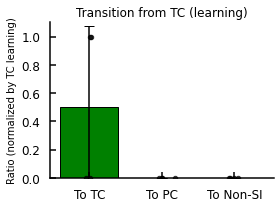

In [21]:
# Convert data to DataFrame
df = pd.DataFrame(PC_ratios_cluster).T
colors=['green','#7D3C98','grey']

# Calculate mean and standard deviation for 'tc_became_tc', 'pc_became_tc', and 'non_si_became_tc' across all animals
mean_values = df[['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']].mean()
std_devs = df[['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']].std()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))

# Bar chart for the averages with standard deviation error bars
ax.bar(mean_values.index, mean_values, yerr=std_devs, color=colors, edgecolor='k', capsize=5, label='Mean ± SD')

# Overlay individual data points for each animal around the mean
for i, column in enumerate(['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']):
    x_positions = np.random.normal(i, 0.05, size=len(df))  # Slight jitter for clear visualization
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Update x-axis labels
ax.set_xticks(range(len(mean_values.index)))  # Set the number of ticks
ax.set_xticklabels(['To TC', 'To PC', 'To Non-SI'])  # New labels

# Labels and title
ax.set_ylabel('Ratio (normalized by TC learning)')
ax.set_title('Transition from TC (learning)')

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits and tick parameters
plt.ylim([0, 1.1])
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(1.5)

# Add legend
#ax.legend()

# Tight layout and show plot
for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'Cluster TC to Non_TC over TC learning new.svg', format='svg',dpi=300)
plt.show()

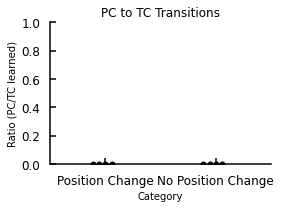

In [22]:



pooled_no_position_change=[PC_Transitions_cluster[animal]['PC_arm_became_TC_arm']+PC_Transitions_cluster[animal]['PC_stem_became_TC_stem'] for animal in PC_Transitions_cluster.keys()]
pooled_position_change=[PC_Transitions_cluster[animal]['PC_arm_became_TC_stem']+PC_Transitions_cluster[animal]['PC_stem_became_TC_arm'] for animal in PC_Transitions_cluster.keys()]

averages = {
    'Position Change': np.mean(pooled_position_change),
    'No Position Change': np.mean(pooled_no_position_change)
}
std_devs = {
    'Position Change': np.std(pooled_position_change),
    'No Position Change': np.std(pooled_no_position_change)
}






# Create a DataFrame to use with Seaborn

data = pd.DataFrame({
    'Value': pooled_position_change + pooled_no_position_change,
    'Category': ['Position Change'] * len(pooled_position_change) + ['No Position Change'] * len(pooled_no_position_change)
})

# Prepare data for plotting
merged_keys = list(averages.keys())
merged_avg_values = list(averages.values())
merged_std_values = list(std_devs.values())
merged_colors = ['blue', 'green']  # Colors for the two categories
# Define a neutral color scheme (grey tones) for both categories
colors = ['#CC5500', '#DAA881']  # Light grey and dark grey
colors = ['#CC5500', '#DAA881']  # Light grey and dark grey

# Plot with adjusted bar width
plt.figure(figsize=(4, 3))
plt.bar(merged_keys, merged_avg_values, yerr=merged_std_values, capsize=5, color=colors, edgecolor='black', width=0.5)

# Overlay swarmplot
sns.swarmplot(data=data, x='Category', y='Value', color='black', size=6, edgecolor='black')



# Labels and Title
plt.ylabel('Ratio (PC/TC learned)', fontsize=10)
plt.title('PC to TC Transitions', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.gca().spines['top'].set_visible(False)

# Optionally hide the right spine as well
plt.gca().spines['right'].set_visible(False)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0,1])

for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'Cluster PC to TC over TC learned new.svg', format='svg',dpi=300)
plt.show()


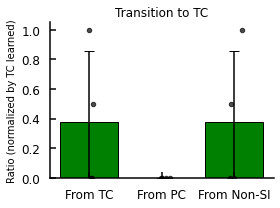

In [23]:

# Convert data to DataFrame
df = pd.DataFrame(PC_ratios_cluster).T

# Calculate mean and standard deviation for 'tc_became_tc', 'pc_became_tc', and 'non_si_became_tc' across all animals
mean_values = df[['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']].mean()
std_devs = df[['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']].std()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))

# Bar chart for the averages with standard deviation error bars
ax.bar(mean_values.index, mean_values, yerr=std_devs, color='green', edgecolor='k', capsize=5, label='Mean ± SD')

# Overlay individual data points for each animal around the mean
for i, column in enumerate(['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']):
    x_positions = np.random.normal(i, 0.05, size=len(df))  # Slight jitter for clear visualization
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Update x-axis labels
ax.set_xticks(range(len(mean_values.index)))  # Set the number of ticks
ax.set_xticklabels(['From TC', 'From PC', 'From Non-SI'])  # New labels

# Labels and title
ax.set_ylabel('Ratio (normalized by TC learned)')
ax.set_title('Transition to TC')

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits and tick parameters
plt.ylim([0, 1.05])
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(1.5)

# Add legend
#ax.legend()

# Tight layout and show plot
for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'Cluster Non_TC to TC over TC learned new.svg', format='svg',dpi=300)
plt.show()

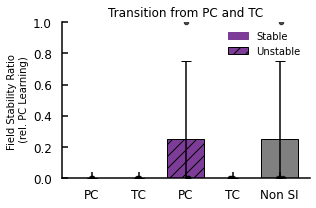

In [24]:
# Convert data to DataFrame and select last three columns
df = pd.DataFrame(PC_Stability).T
import matplotlib.patches as mpatches
# Calculate means and standard deviations
means = df.mean()
std_devs = df.std()

# Plotting
fig, ax = plt.subplots(figsize=(4.5, 3))

# Define colors and patterns for bars
colors = ['#7D3C98', 'green', '#7D3C98', 'green', 'grey']
patterns = [None, None, '//', '//', None]  # Use patterns for unstable

# Bar chart with error bars
bars = ax.bar(means.index, means, yerr=std_devs, capsize=5, color=colors, edgecolor='k')

# Apply patterns to bars
for bar, pattern in zip(bars, patterns):
    if pattern:
        bar.set_hatch(pattern)

# Overlay individual data points
for i, column in enumerate(df.columns):
    x_positions = np.random.normal(i, 0.05, size=len(df))
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Adjust x-axis labels
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(['PC', 'TC', 'PC', 'TC', 'Non SI'])

# Labels and legend
ax.set_ylabel('Field Stability Ratio \n (rel. PC Learning)')
ax.set_title('Transition from PC and TC')

# Create legend with patterns
stable_patch = mpatches.Patch(color='#7D3C98', label='Stable')
unstable_patch = mpatches.Patch(facecolor='#7D3C98', edgecolor='k', label='Unstable', hatch='//')
legend = ax.legend(handles=[stable_patch, unstable_patch], loc='upper right', fontsize=10, frameon=False)

# Format plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0, 1])

for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)

plt.tight_layout()

plt.savefig(savefolder+'Cluster PC stability transition new.svg', format='svg',dpi=300)
plt.show()

In [25]:
# Compute the transitions between learning and learned conditions
transitions_ratios = pf.compute_significant_transitions_new(cluster_type_mask_phases)


avg_transitions_with_remained = pf.compute_average_transitions_with_remained_new(transitions_ratios)


In [26]:

def compute_average_ratios(ratios):
    avg_ratios = {}
    std_ratios={}
    for region in ratios[next(iter(ratios))]:  # Loop over regions using the first animal's keys
        region_values = [ratios[animal][region] for animal in ratios]
        avg_ratios[region] = np.mean(region_values)
        std_ratios[region] = np.std(region_values)

    return avg_ratios,std_ratios

In [27]:

# Example for the 'learning' condition
learning_ratios = pf.compute_significant_ratios(cluster_type_mask_phases, 'learning')
learned_ratios = pf.compute_significant_ratios(cluster_type_mask_phases, 'learned')

# Compute average for learning and learned ratios
avg_learning_ratios,std_learning_ratios = compute_average_ratios(learning_ratios)
avg_learned_ratios,std_learned_ratios = compute_average_ratios(learned_ratios)


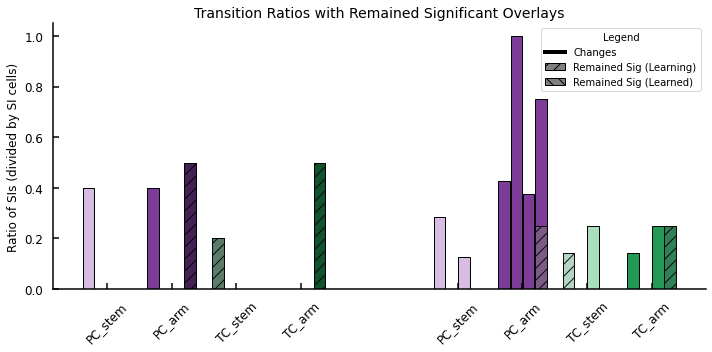

In [28]:
remained_sig_ratios_learning = {}
remained_sig_ratios_learned = {}

for animal_id, categories in transitions_ratios.items():
    remained_sig_ratios_learning[animal_id] = {}
    remained_sig_ratios_learned[animal_id] = {}
    for category, values in categories.items():
        # Grab the "Remained Sig (Learning)" and "Remained Sig (Learned)" values
        remained_sig_ratios_learning[animal_id][category] = values.get('Remained Sig (Learning)', 0)
        remained_sig_ratios_learned[animal_id][category] = values.get('Remained Sig (Learned)', 0)

# Define regions and colors
regions = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm']
#colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954']
colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954']

overlay_colors_learning = ['#6c5e71', '#3e1e4c', '#547060', '#114c2a']
overlay_colors_learned = ['#c4b9cd', '#7e5e85', '#b6d3c7', '#347d56']
labels = ['Learning', 'Learned']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.15  # Width of each individual bar
tiny_gap = 0.01   # Smaller gap between each animal within the same region
group_gap = 0.2   # Reduced gap between categories within the same stage
stage_gap = 2.0   # Larger gap between the "learning" and "learned" stages

# Calculate x positions for each region and animal within each stage
x_learning = []
x_learned = []
for i, region in enumerate(regions):
    # Learning stage x positions for each animal within the region
    x_learning.extend(np.arange(len(learning_ratios)) * (bar_width + tiny_gap) + i * (len(learning_ratios) * (bar_width + tiny_gap) + group_gap))
    # Learned stage x positions, offset by stage_gap
    x_learned.extend(np.array(x_learning[-len(learning_ratios):]) + (len(regions) * len(learning_ratios) * (bar_width + tiny_gap) + stage_gap))

# Plot each region within the "learning" stage with Remained Sig overlay
for i, (region, color, overlay_color) in enumerate(zip(regions, colors, overlay_colors_learning)):
    for idx, animal in enumerate(learning_ratios.keys()):
        x = x_learning[idx + i * len(learning_ratios)]
        main_value = learning_ratios[animal][region]
        
        # Main bar
        ax.bar(x, main_value, width=bar_width, color=color, edgecolor='black', label=region if idx == 0 else "")
        
        # Remained Sig overlay (Learning)
        overlay_value_learning = remained_sig_ratios_learning[animal][region]
        ax.bar(x, overlay_value_learning, width=bar_width, color=overlay_color, edgecolor='black', alpha=0.9, hatch='//')

# Plot each region within the "learned" stage with Remained Sig overlay
for i, (region, color, overlay_color) in enumerate(zip(regions, colors, overlay_colors_learned)):
    for idx, animal in enumerate(learned_ratios.keys()):
        x = x_learned[idx + i * len(learned_ratios)]
        main_value = learned_ratios[animal][region]
        
        # Main bar
        ax.bar(x, main_value, width=bar_width, color=color, edgecolor='black')
        
        # Remained Sig overlay (Learned)
        overlay_value_learned = remained_sig_ratios_learned[animal][region]
        ax.bar(x, overlay_value_learned, width=bar_width, color=overlay_color, edgecolor='black', alpha=0.9, hatch='//')

# Customize plot
category_midpoints_learning = [np.mean(x_learning[i * len(learning_ratios):(i + 1) * len(learning_ratios)]) for i in range(len(regions))]
category_midpoints_learned = [np.mean(x_learned[i * len(learned_ratios):(i + 1) * len(learned_ratios)]) for i in range(len(regions))]
ax.set_xticks(category_midpoints_learning + category_midpoints_learned)
ax.set_xticklabels(regions * 2, fontsize=12, rotation=45)
ax.set_ylabel('Ratio of SIs (divided by SI cells)', fontsize=12)
ax.set_title('Transition Ratios with Remained Significant Overlays', fontsize=14)

# Update legend
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Define legends
solid_line = mlines.Line2D([], [], color='black', lw=4, label='Changes')
hatched_patch_learning = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='//', label='Remained Sig (Learning)')
hatched_patch_learned = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='\\\\', label='Remained Sig (Learned)')

# Combine into a single legend
ax.legend(handles=[solid_line, hatched_patch_learning, hatched_patch_learned], loc='upper right', title='Legend')

# Hide top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for ax in [ax]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()

plt.savefig(savefolder + 'Cluster_Transition_Ratios_with_Remained_Significant new.svg',  format="svg",dpi=300)
plt.show()

In [29]:
allfolders2=['478','481','483','485']
#allfolders2=['485']

#allfolders2=['483']

direction=['L','R']
rate_L_R={}
for fol1 in allfolders2:
    PC_frac_dir={}

    for dir in direction:
        #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
       
        cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_Cell',allow_pickle=True)

        rate_L_R[fol1+'_'+dir]=cluster_pc_fractions#['rate_all']

In [30]:
import random

In [31]:
def distance_cell_to_cluster(cluster_rate_all_animals,Cluster_types_all,cell_idx,rate_L_R,animal_name,plotrates):
    #'original':[],'shuffled':[]
    c2c_Distances={}
    c2c_Distances_sh={}
    for cell_tpe in Cluster_types_all[animal_name].keys():# type
        
        rate_cluster=[]
        for ic, tmp_nbr in enumerate(Cluster_types_all[animal_name][cell_tpe]):# cluster
            rate_cell=[]
            distance_cell_to_cluster_org=[]
            distance_cell_to_cluster_shuffled=[]
            for cell_nbr in cell_idx[tmp_nbr]:# cells
                #dist=np.abs(np.argmax(rate_L_R[animal_name+'_L']['rate_all'][cell_nbr])-np.argmax(cluster_rate_all_animals[animal_name]['L'][tmp_nbr]))
                dist=(np.argmax(rate_L_R[animal_name+'_L']['rate_all'][cell_nbr])-np.argmax(cluster_rate_all_animals[animal_name]['L'][tmp_nbr]))

                distance_cell_to_cluster_org.append(dist)
                
                distance_cell_to_cluster_shuffled_cell=[]# shuffled dictance for each cell

                for sh in range(1000):
                    rmap=rate_L_R[animal_name+'_L']['rate_all'][cell_nbr]
                    rate_sh= np.roll(rmap,  random.randint(1, len(rmap) - 1))# shuffle rate map
                    #dist_sh=np.abs(np.argmax(rate_sh)-np.argmax(cluster_rate_all_animals[animal_name]['L'][tmp_nbr]))
                    dist_sh=(np.argmax(rate_sh)-np.argmax(cluster_rate_all_animals[animal_name]['L'][tmp_nbr]))

                    distance_cell_to_cluster_shuffled_cell.append(dist_sh)




                # mean_distance_sh=[]
                # for ish in range(len(rate_L_R[animal_name+'_L']['rate_all_shuffled'])):
                #     dist_sh=np.abs(np.argmax(rate_L_R[animal_name+'_L']['rate_all_shuffled'][ish][cell_nbr])-np.argmax(cluster_rate_all_animals[animal_name]['L'][tmp_nbr]))
                #     distance_cell_to_cluster_shuffled_cell.append(dist_sh)
                distance_cell_to_cluster_shuffled.append(distance_cell_to_cluster_shuffled_cell)# distances of all shuffled data to cluster
                
                
                p_val=np.sum(dist>distance_cell_to_cluster_shuffled_cell)/len(distance_cell_to_cluster_shuffled_cell)
                #print(cell_tpe+str(tmp_nbr)+'_'+str(cell_nbr)+':',p_val)
                rate_cell.append(rate_L_R[animal_name+'_L']['rate_all'][cell_nbr])

                # plt.figure()
                # plt.hist(distance_cell_to_cluster_shuffled_cell,alpha=.2)
                # plt.vlines(dist,0,100,color='r')
                # plt.title(cell_tpe+str(tmp_nbr)+'_'+str(cell_nbr)+':'+str(p_val))


                #mean_distance_sh.append(np.mean(distance_cell_to_cluster_shuffled_cell))# avg of shuffled for each cell

            #p_val_all_cells=np.sum(mean_distance_sh>distance_cell_to_cluster)/len(distance_cell_to_cluster_shuffled_cell)# compare distance to clusters for all cells with the average of the shuffled


            # c2c_Distances[cell_tpe+str(ic)]=distance_cell_to_cluster_org
            # c2c_Distances_sh[cell_tpe+str(ic)]=distance_cell_to_cluster_shuffled

            c2c_Distances[cell_tpe+str(tmp_nbr)]=distance_cell_to_cluster_org
            c2c_Distances_sh[cell_tpe+str(tmp_nbr)]=distance_cell_to_cluster_shuffled


            rate_cluster.append(cluster_rate_all_animals[animal_name]['L'][tmp_nbr])

            if plotrates:
                fig, (ax,ax2) = plt.subplots(1, 2,figsize=(8, 6))
                im = ax.pcolormesh(y_ax, np.arange(np.shape(rate_cell)[0]), rate_cell)

                
                plt.colorbar(im, ax=ax)
                plt.subplot(122)
                ax.set_title('Cell rate maps'+ animal_name+cell_tpe+str(tmp_nbr))
                #fig, ax = plt.subplots(figsize=(16, 8))
                #im = ax2.pcolormesh(y_ax, np.arange(np.shape(cluster_pc_fractions_L['rate_significant'])[0]), cluster_pc_fractions_L['rate_significant'])

                # if len (rate_cluster)>1:
                #     im = ax2.pcolormesh(y_ax, np.arange(np.shape(rate_cluster)[0]), rate_cluster)
                # else:

                ax2.plot(cluster_rate_all_animals[animal_name]['L'][tmp_nbr])


                # plt.colorbar(im, ax=ax2)
                ax2.set_title('cluster'+ animal_name+cell_tpe+str(tmp_nbr))
                # plt.suptitle('Target cells \n'+'Median of correlation beween R and L runs Arms: '+"%.2f"%(np.nanmedian(np.asarray(similarity_between_l_and_r_all)[mask_cut & mask_corr])))

                # plt.figure()
                # plt.hist(distance_cell_to_cluster)
                # plt.title('distance to cluster'+ animal_name+cell_tpe+str(tmp_nbr))

    return c2c_Distances,c2c_Distances_sh

In [32]:
# Create a function to process data for each animal
def process_data(data, animal_id):
    clusters = {}
    for key, value in data.items():
        cluster = key.split('_')[1]
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(value)

    significant_threshold = 0.05
    percent_significant = {}
    for cluster, p_values in clusters.items():
        significant_count = sum(1 for p in p_values if p < significant_threshold)
        percent_significant[cluster] = (significant_count / len(p_values)) * 100

    return pd.DataFrame.from_dict(percent_significant, orient='index', columns=[f'Animal_{animal_id}_Percentage'])


In [33]:
phase='learned'

Cluster_types_all=Cluster_type[phase]
cluster_rate_all_animals=Cluster_rate[phase]
#cluster_rate_all_animals=Rates_cluster2[phase]

cell_types_all_phases=np.load(savefolder+'_Cell_types',allow_pickle=True)# impport cell types
cell_types_all=cell_types_all_phases[phase]

In [34]:
rate_L_R['478_L'].keys()

dict_keys(['rate_all', 'rate_all_shuffled', 'significant', 'pvalues', 'insignificant', 'all_L_norm', 'Clusters'])

In [35]:
# compare distances between peaks of the cells of each cluster(template) with its rate map 
import random
plotrates=False
#animal_name='485'
all_dfs = []
pval_all_animals_precent={}
distance_all_animals={}
distance_all_animals_sh={}
pval_all_animals={}

for animal_name in allfolders2:


    dir_of_run='L'
    filename = animal_name+'outward_'+dir_of_run+'_learned_correct_Cell'
    data_animal = np.load(join(savefolder, filename), allow_pickle=True)

    sessinfo_and_mask=np.load(savefolder+animal_name+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)

    
    
    c2c_Distances,c2c_Distances_sh= pf.distance_cell_to_cluster2(cluster_rate_all_animals,Cluster_types_all,sessinfo_and_mask['sess_info']['template'],rate_L_R,animal_name,plotrates)# get distance of cells to clustesr for original and shuffled
    

    pvals_all_cells=[]
    pvals_={}
    for cltyp in c2c_Distances.keys():
        for icl,clnbr in enumerate(c2c_Distances[cltyp]):
            #pvals.append(np.sum(c2c_Distances[cltyp][icl]>c2c_Distances_sh[cltyp][icl])/len(c2c_Distances_sh[cltyp][icl]))
            pvals_[cltyp+'_'+str(icl)]=1-np.sum(abs(c2c_Distances[cltyp][icl])<[abs(num) for num in c2c_Distances_sh[cltyp][icl]])/len(c2c_Distances_sh[cltyp][icl])

    
    distance_all_animals[animal_name]=c2c_Distances
    distance_all_animals_sh[animal_name]=c2c_Distances_sh
    pval_all_animals[animal_name]=pvals_
    
    
    df_animal_1 = process_data(pvals_, animal_name)# merge pvalues 
    #all_dfs.append(df_animal_1)

    pval_all_animals_precent[animal_name]=dict(df_animal_1)   
#combined_df = pd.concat(all_dfs, axis=1)

In [36]:
def plot_distance_distributins(distance_all_animals_type,distance_all_animals_type_sh):
    bin_range=(-1000, 1000)
    bin_size=50
    bins = np.arange(bin_range[0], bin_range[1] + bin_size, bin_size)  # Fixed bins from 0 to 1000 with step of 30

    for animal, clusters in distance_all_animals_type.items():

        num_clusters = len(clusters)
        if num_clusters > 0:
            fig, axs = plt.subplots(num_clusters, 1, figsize=(5, 3 * num_clusters), constrained_layout=True)
            fig.suptitle(f'Distributions for Animal {animal}'+' Cell Type')
            
            for idx, (cluster, values) in enumerate(clusters.items()):
                ax = axs[idx] if num_clusters > 1 else axs
                # Normalize histogram
                #bins=np.range(1000)
                hist, bin_edges = np.histogram(values, bins=bins, density=False)
                # Plot normalized histogram
                ax.bar(bin_edges[:-1], hist/np.sum(hist), width=np.diff(bin_edges), edgecolor='black', alpha=0.7, label=cluster)



                hist, bin_edges = np.histogram([item for sublist in distance_all_animals_type_sh[animal][cluster] for item in sublist], bins=bins, density=False)
                ax.bar(bin_edges[:-1], hist/np.sum(hist), width=np.diff(bin_edges), edgecolor='white', alpha=0.4, label='shuffled')





                ax.set_title(f'Distribution of {cluster}')
                ax.set_xlabel('Distance')
                ax.set_ylabel('Normalized Frequency')
                ax.legend()

            plt.show()

In [37]:
sessinfo_and_mask.keys()

dict_keys(['sess_info', 'Masks'])

In [38]:
# compare distances between peaks of the cells of different types with clusters(template) with its rate map 

#animal_name='485'
all_dfs = []
pval_all_animals_type_precent={}
distance_all_animals_type={}
distance_all_animals_type_sh={}
for animal_name in allfolders2:


    dir_of_run='L'
    filename = animal_name+'outward_'+dir_of_run+'_learned_correct_Cell'
    data_animal = np.load(join(savefolder, filename), allow_pickle=True)
    sessinfo_and_mask=np.load(savefolder+animal_name+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)
    sessinfo_=sessinfo_and_mask['sess_info']
    #cell_Rates=cell_types_all[animal_name]['TC_arm']
    c2c_Distances,c2c_Distances_sh= pf.distance_cell_to_cluster_type2(cluster_rate_all_animals,sessinfo_,Cluster_types_all,rate_L_R,cell_types_all,animal_name,False)# get distance of cells to clustesr for original and shuffled


    pvals_all_cells=[]
    pvals_={}
    for cltyp in c2c_Distances.keys():
        for icl,clnbr in enumerate(c2c_Distances[cltyp]):
                #pvals.append(np.sum(c2c_Distances[cltyp][icl]>c2c_Distances_sh[cltyp][icl])/len(c2c_Distances_sh[cltyp][icl]))
                pvals_[cltyp+'_'+str(icl)]=1-np.sum(abs(c2c_Distances[cltyp][icl])<[abs(x)for x in c2c_Distances_sh[cltyp][icl]])/len(c2c_Distances_sh[cltyp][icl])

    distance_all_animals_type[animal_name]=c2c_Distances
    distance_all_animals_type_sh[animal_name]=c2c_Distances_sh

    
    df_animal_1 = process_data(pvals_, animal_name)# merge pvalues 
    #all_dfs.append(df_animal_1)

    pval_all_animals_type_precent[animal_name]=dict(df_animal_1)   
#combined_df = pd.concat(all_dfs, axis=1

In [39]:
# Compare distribution of distances to clusters all cells vs TC/PC
from scipy.stats import mannwhitneyu

dict1=distance_all_animals_type
dict2=distance_all_animals
# Initialize a list to store comparison results
comparison_results = []

# Compare contents of each key pairwise
for key in dict1:
    if key in dict2:
        subkeys1 = dict1[key].keys()
        subkeys2 = dict2[key].keys()
        all_subkeys = set(subkeys1).union(set(subkeys2))
        
        for subkey in all_subkeys:
            list1 = dict1[key].get(subkey, [])
            list2 = dict2[key].get(subkey, [])
            if list1 and list2:
                stat, p_value = mannwhitneyu(list1, list2, alternative='two-sided')
            else:
                p_value = None
            comparison_results.append({'Animal': key, 'Cluster': subkey, 'p_value': p_value})

# Convert the results to a DataFrame
df_results = pd.DataFrame(comparison_results)

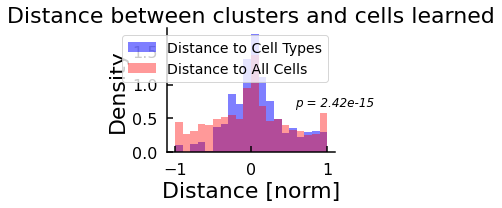

In [40]:
# Step 1: Merge data for all animals in both dictionaries
all_values_data1 = []
all_values_data2 = []
# Merging data for data1
for animal_data in distance_all_animals_type.values():
    for cluster_data in animal_data.values():
        all_values_data1.extend(cluster_data)

# Merging data for data2
for animal_data in distance_all_animals.values():
    for cluster_data in animal_data.values():
        all_values_data2.extend(cluster_data)
norm = 1000

# Define custom bins
custom_bins = np.linspace(-1, 1, 21)  # 20 bins between -1 and 1
bin_width = np.diff(custom_bins)[0]

# Compute histogram and normalize to PDF
hist, bin_edges = np.histogram(np.asarray(all_values_data1) / norm, bins=custom_bins)
hist = hist / (np.sum(hist) * bin_width)

hist2, bin_edges2 = np.histogram(np.asarray(all_values_data2) / norm, bins=custom_bins)
hist2 = hist2 / (np.sum(hist2) * bin_width)

stat, p_value = mannwhitneyu(np.abs(all_values_data1), np.abs(all_values_data2), alternative='less')
# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the PDFs
plt.figure(figsize=(4, 3))
plt.bar(bin_centers, hist, width=bin_width, color='blue', alpha=0.5, label='Distance to Cell Types')
plt.bar(bin_centers, hist2, width=bin_width, color='red', alpha=0.4, label='Distance to All Cells')
plt.text(1, 0.4, f'p = {p_value:.2e}', fontstyle='italic', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.xlabel('Distance [norm]',fontsize=22)
plt.ylabel('Density',fontsize=22)
plt.title('Distance between clusters and cells '+phase,fontsize=22)
plt.legend(fontsize=14)
hide_spines()
# Show the plot
plt.tight_layout()
#plt.grid(True)
#plt.savefig(savefolder+'Distance_cetners_'+phase+'new.svg',format='svg',dpi=30)
plt.show()

In [41]:
boz

NameError: name 'boz' is not defined

In [ ]:


# Function to test if the sum of a histogram equals 1
def is_pdf(hist_values, bin_edges):
    """
    Check if the histogram is a properly normalized PDF (area under the curve = 1).
    
    Parameters:
        hist_values (array): Array of histogram values (heights).
        bin_edges (array): Array of bin edges.
        
    Returns:
        bool: True if sum of the histogram (area under curve) is approximately 1, otherwise False.
    """
    bin_widths = np.diff(bin_edges)
    area = np.sum(hist_values * bin_widths)
    print(area)
    return np.isclose(area, 1.0)

# Test if the histogram is a valid PDF
is_pdf(hist2, bin_edges2)


1.0000000000000002


True

In [42]:

# Compare distribution of distances to clusters all cells vs cluseter types (TC/PC)
from scipy.stats import mannwhitneyu
dict1=distance_all_animals_type
dict2=distance_all_animals
# Initialize a list to store comparison results
comparison_results = []

# Compare contents of each key pairwise
for key in dict1:
    if key in dict2:
        subkeys1 = dict1[key].keys()
        subkeys2 = dict2[key].keys()
        all_subkeys = set(subkeys1).union(set(subkeys2))
        
        for subkey in all_subkeys:
            list1 = dict1[key].get(subkey, [])
            list2 = dict2[key].get(subkey, [])
            if list1 and list2:
                stat, p_value = mannwhitneyu(np.abs(list1), np.abs(list2), alternative='less')
            else:
                p_value = None
            comparison_results.append({'Animal': key, 'Cluster': subkey, 'p_value': p_value})
           # plot_dist_hist(list1,list2,norm,custom_bins,name={'Animal': key, 'Cluster': subkey, 'p_value': p_value})
        if len(all_subkeys)==0:
            p_value=subkey=None
            comparison_results.append({'Animal': key, 'Cluster': subkey, 'p_value': p_value})
# Convert the results to a DataFrame
df_results = pd.DataFrame(comparison_results)

In [43]:
def plot_dist_hist(list1,list2,norm,custom_bins,name):
    # show the histogram of distances between clusters and cells
    # Compute histogram
    hist, bin_edges = np.histogram(np.asarray(list1)/norm, bins=custom_bins)
    hist=hist/np.sum(hist)
    hist2, bin_edges2 = np.histogram(np.asarray(list2)/norm, bins=custom_bins)
    hist2=hist2/np.sum(hist2)

    # Plot the histogram manually
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
    bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2  # Calculate bin centers for plotting

   # stat, p_value = mannwhitneyu(np.abs(list1), np.abs(list2), alternative='greater')

    # Step 2: Plot the overlaid distributions
    plt.figure(figsize=(5, 3))

    # Plot for data1
    plt.bar(bin_centers, hist, width=np.diff(bin_edges), color='blue', alpha=0.5, label='Distance to Cell Types')
    plt.bar(bin_centers2, hist2, width=np.diff(bin_edges2), color='red', alpha=0.4, label='Distance to All Cells')
    #plt.text(.5,.1,str(p_value))
    #plt.text(1, 0.4, f'p = {p_value:.2e}', fontstyle='italic', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(name)

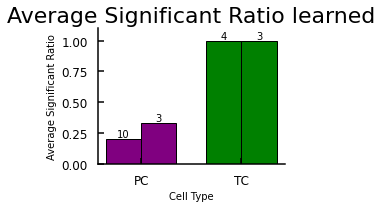

In [44]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Create a DataFrame
df = pd.DataFrame(df_results)

# Drop rows with missing 'p_value' or 'Cluster'
df = df.dropna(subset=['p_value', 'Cluster'])

# Create a 'Significant' column (p_value < 0.05)
df['Significant'] = df['p_value'] < 0.05

# Extract 'Region' and 'Cell_Type' from 'Cluster'
df['Region'] = df['Cluster'].str.split('_').str[1]
df['Cell_Type'] = df['Cluster'].str.split('_').str[0]

# Filter valid rows with Region_Type
df = df[df['Region'].notna()]

# Determine Region_Type (Arm or Stem)
df['Region_Type'] = df['Region'].apply(lambda x: 'Arm' if 'arm' in x.lower() else 'Stem' if 'stem' in x.lower() else None)

# Group by Cell_Type and Region_Type to calculate mean significant ratio
region_significant_ratios = df.groupby(['Cell_Type', 'Region_Type'])['Significant'].mean().reset_index()

# Calculate total counts (both significant and non-significant)
total_counts = df.groupby(['Cell_Type', 'Region_Type']).size().reset_index(name='Total_Count')

# Merge ratios and counts
region_merged_data = pd.merge(region_significant_ratios, total_counts, on=['Cell_Type', 'Region_Type'], how='outer')

# Replace NaN with 0 for missing combinations
region_merged_data['Significant'] = region_merged_data['Significant'].fillna(0)
region_merged_data['Total_Count'] = region_merged_data['Total_Count'].fillna(0)

# Separate values for PC_Arm, PC_Stem, TC_Arm, TC_Stem
def get_value(cell_type, region_type, column):
    result = region_merged_data[
        (region_merged_data['Cell_Type'] == cell_type) & 
        (region_merged_data['Region_Type'] == region_type)
    ][column]
    return result.values[0] if not result.empty else 0

pc_arm = get_value("PC", "Arm", "Significant")
pc_stem = get_value("PC", "Stem", "Significant")
tc_arm = get_value("TC", "Arm", "Significant")
tc_stem = get_value("TC", "Stem", "Significant")

# Bar heights
pc_values = [pc_arm, pc_stem]
tc_values = [tc_arm, tc_stem]

# Total counts
pc_totals = [get_value("PC", "Arm", "Total_Count"), get_value("PC", "Stem", "Total_Count")]
tc_totals = [get_value("TC", "Arm", "Total_Count"), get_value("TC", "Stem", "Total_Count")]

# Adjust positions for Arm and Stem bars within each group
bar_width = 0.35
x_positions = np.array([0, 1])  # PC and TC groups
pc_positions = x_positions[0] + np.array([-bar_width / 2, bar_width / 2])  # Left group
tc_positions = x_positions[1] + np.array([-bar_width / 2, bar_width / 2])  # Right group

# Plot bars
plt.figure(figsize=(3.5, 3))
pc_bars = plt.bar(pc_positions, pc_values, bar_width, label="PC", alpha=1, color="purple", edgecolor='k')
tc_bars = plt.bar(tc_positions, tc_values, bar_width, label="TC", alpha=1, color="green", edgecolor='k')

# Add text annotations for total counts
for bar, total in zip(pc_bars, pc_totals):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(total)}',
             ha='center', va='bottom', fontsize=10)

for bar, total in zip(tc_bars, tc_totals):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(total)}',
             ha='center', va='bottom', fontsize=10)

# Customize x-axis labels
plt.xticks(x_positions, ["PC", "TC"])
hide_spines()
# Adding title and labels
plt.title('Average Significant Ratio '+phase,fontsize=22)
plt.xlabel('Cell Type')
plt.ylabel('Average Significant Ratio')

# Aesthetic adjustments
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(savefolder+'Distance_significant_ratio'+phase+'new.svg', format='svg',dpi=300)

# Show plot
plt.show()


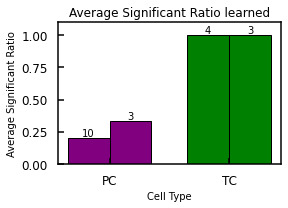

In [45]:
# Create a DataFrame
df = pd.DataFrame(df_results)

# Drop rows with missing 'p_value' or 'Cluster'
df = df.dropna(subset=['p_value', 'Cluster'])

# Create a 'Significant' column (p_value < 0.05)
df['Significant'] = df['p_value'] < 0.05

# Extract 'Region' and 'Cell_Type' from 'Cluster'
df['Region'] = df['Cluster'].str.split('_').str[1]
df['Cell_Type'] = df['Cluster'].str.split('_').str[0]

# Filter valid rows with Region_Type
df = df[df['Region'].notna()]

# Determine Region_Type (Arm or Stem)
df['Region_Type'] = df['Region'].apply(lambda x: 'Arm' if 'arm' in x.lower() else 'Stem' if 'stem' in x.lower() else None)

# Group by Cell_Type and Region_Type to calculate mean significant ratio
region_significant_ratios = df.groupby(['Cell_Type', 'Region_Type'])['Significant'].mean().reset_index()

# Calculate total counts (both significant and non-significant)
total_counts = df.groupby(['Cell_Type', 'Region_Type']).size().reset_index(name='Total_Count')

# Merge ratios and counts
region_merged_data = pd.merge(region_significant_ratios, total_counts, on=['Cell_Type', 'Region_Type'], how='outer')

# Replace NaN with 0 for missing combinations
region_merged_data['Significant'] = region_merged_data['Significant'].fillna(0)
region_merged_data['Total_Count'] = region_merged_data['Total_Count'].fillna(0)

# Separate values for PC_Arm, PC_Stem, TC_Arm, TC_Stem
def get_value(cell_type, region_type, column):
    result = region_merged_data[
        (region_merged_data['Cell_Type'] == cell_type) & 
        (region_merged_data['Region_Type'] == region_type)
    ][column]
    return result.values[0] if not result.empty else 0

pc_arm = get_value("PC", "Arm", "Significant")
pc_stem = get_value("PC", "Stem", "Significant")
tc_arm = get_value("TC", "Arm", "Significant")
tc_stem = get_value("TC", "Stem", "Significant")

# Bar heights
pc_values = [pc_arm, pc_stem]
tc_values = [tc_arm, tc_stem]

# Total counts
pc_totals = [get_value("PC", "Arm", "Total_Count"), get_value("PC", "Stem", "Total_Count")]
tc_totals = [get_value("TC", "Arm", "Total_Count"), get_value("TC", "Stem", "Total_Count")]

# Adjust positions for Arm and Stem bars within each group
bar_width = 0.35
x_positions = np.array([0, 1])  # PC and TC groups
pc_positions = x_positions[0] + np.array([-bar_width / 2, bar_width / 2])  # Left group
tc_positions = x_positions[1] + np.array([-bar_width / 2, bar_width / 2])  # Right group

# Plot bars
plt.figure(figsize=(4, 3))
pc_bars = plt.bar(pc_positions, pc_values, bar_width, label="PC", alpha=1, color="purple", edgecolor='k')
tc_bars = plt.bar(tc_positions, tc_values, bar_width, label="TC", alpha=1, color="green", edgecolor='k')

# Add text annotations for total counts
for bar, total in zip(pc_bars, pc_totals):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(total)}',
             ha='center', va='bottom', fontsize=10)

for bar, total in zip(tc_bars, tc_totals):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(total)}',
             ha='center', va='bottom', fontsize=10)

# Customize x-axis labels
plt.xticks(x_positions, ["PC", "TC"])

# Adding title and labels
plt.title('Average Significant Ratio '+phase)
plt.xlabel('Cell Type')
plt.ylabel('Average Significant Ratio')

# Aesthetic adjustments
plt.ylim(0, 1.1)
plt.tight_layout()

# Show plot
plt.show()


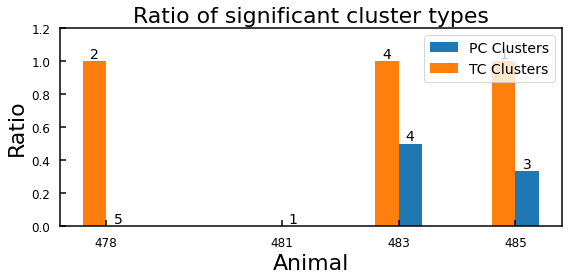

In [46]:
import pandas as pd
import matplotlib.pyplot as plt



# Create a DataFrame
df = pd.DataFrame(df_results)

# Handle missing values by filling Cluster with 'Unknown' and p_value with NaN by forward filling
df['Cluster'] = df['Cluster'].fillna('Unknown')
df['p_value'] = df['p_value'].fillna(1.0)  # Treat missing p-values as non-significant

# Create a new column to indicate the cluster type (TC or PC)
df['Cluster_Type'] = df['Cluster'].apply(lambda x: 'TC' if 'TC' in x else ('PC' if 'PC' in x else 'Unknown'))

# Create a new column to indicate whether the p_value is significant
df['significant'] = df['p_value'] < 0.05

# Grouping data by Animal and Cluster_Type to count the number of significant p-values
significant_counts_per_animal_cluster = df.groupby(['Animal', 'Cluster_Type'])['significant'].sum().reset_index()

# Calculate the total number of clusters per animal and cluster type
total_clusters_per_animal_cluster = df.groupby(['Animal', 'Cluster_Type'])['Cluster'].count().reset_index()

# Merge with the significant counts data
merged_data_cluster = pd.merge(significant_counts_per_animal_cluster, total_clusters_per_animal_cluster, on=['Animal', 'Cluster_Type'])
merged_data_cluster.columns = ['Animal', 'Cluster_Type', 'Significant_Count', 'Total_Clusters_Type']

# Calculate the total number of clusters per animal (sum of both TC and PC)
total_clusters_per_animal = df.groupby('Animal')['Cluster'].count().reset_index()
total_clusters_per_animal.columns = ['Animal', 'Total_Clusters']

# Merge the total clusters with the significant counts data
merged_data_cluster = pd.merge(merged_data_cluster, total_clusters_per_animal, on='Animal')

# Calculate the adjusted proportion by dividing significant PC or TC by the total number of clusters (PC + TC)
merged_data_cluster['Adjusted_Proportion_Significant'] = merged_data_cluster['Significant_Count'] / merged_data_cluster['Total_Clusters_Type']

# Filtering out rows with 'Unknown' in Cluster_Type
filtered_data_cluster = merged_data_cluster[merged_data_cluster['Cluster_Type'] != 'Unknown']
filtered_data_cluster['Animal'] = filtered_data_cluster['Animal'].astype(float)

# Plotting the adjusted proportion of significant clusters per animal and cluster type (TC and PC divided by total clusters of animal)
plt.figure(figsize=(8, 4))
for cluster_type in filtered_data_cluster['Cluster_Type'].unique():
    subset = filtered_data_cluster[filtered_data_cluster['Cluster_Type'] == cluster_type]
    bars=plt.bar(subset['Animal'] + (0.2 if cluster_type == 'PC' else -0.2), subset['Adjusted_Proportion_Significant'], 
            width=0.4, label=f'{cluster_type} Clusters')
    # Adding the total number of clusters on top of each bar
    for bar, total in zip(bars, subset['Total_Clusters_Type']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(total)}', 
                 ha='center', va='bottom',fontsize=14)
plt.xlabel('Animal',fontsize=22)
plt.ylabel('Ratio',fontsize=22)
#plt.title('Distance of clusters types to cell types and all cells ')
plt.title('Ratio of significant cluster types',fontsize=22)

plt.xticks(filtered_data_cluster['Animal'].unique())
plt.legend(fontsize=14)
plt.tight_layout()
plt.ylim([0,1.2])

# Show the plot
plt.show()


In [47]:
# Load entropy of subsampling 

all_entropies_ss={}
place_cell_name='All'
cell_types='All'
burst_len='0.5s'

descriotor='No_chunk_'+burst_len+'_transients'#+'Randomized_seqs'


conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

In [48]:

cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward
trial_type=1
phase=1




if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'



if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'



session_mask={'20220215_gcamp6f485_task_learning.mat': 0,
 '20220217_gcamp6f485_task_learning.mat': 1,
 '20220218_gcamp6f485_task_learning.mat': 2,
 '20220307_gcamp6f485_task_learned.mat': 3,
 '20220308_gcamp6f485_task_learned.mat': 4,
 '20220309_gcamp6f485_task_learned.mat': 5,
 '20220310_gcamp6f485_task_learned.mat': 6,
 '20220316_gcamp6f485_task_learned.mat': 7}
cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

# cond_number='reward'

sessin_numbers=np.arange(len(session_mask))
if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'

conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_names = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
odd_even=None# all trials

In [49]:
Cond_names_and_numbers={'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7}

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_kl_distributions_ss(js_divergence_ss, p_value_corr_js_, name, type='Correct'):
    plt.figure(figsize=(6, 4))

    # Define KDE plots for a smoother "envelope" effect
    sns.kdeplot(js_divergence_ss[type], bw_adjust=0.5, fill=True, color='#1f77b4', alpha=0.5, 
                linewidth=2, label='Original')
    sns.kdeplot(js_divergence_ss[type + '_sh'], bw_adjust=0.5, fill=True, color='gray', alpha=0.5, 
                linewidth=2, label='Shuffled')
    
    # Set plot title and labels
    plt.title(f"{name[:-2]} ({name[-2:]})", fontsize=14, weight='bold')
    plt.xlabel("Jensen-Shannon Divergence", fontsize=12, weight='bold')
    plt.ylabel('Density', fontsize=12, weight='bold')

    # Add p-value text inside the plot with customized font
    plt.text(0.7, 0.9, f'p = {p_value_corr_js_:.3f}', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12, color='black', style='italic', weight='bold')

    # Improve appearance with gridlines and spine removal
    ax = plt.gca()
    ax.grid(visible=True, which='major', color='gray', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend for clarity
    plt.legend(fontsize=10, frameon=False, loc='upper right')

    # Final adjustments for a cleaner look
    plt.tight_layout()
    return ax


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


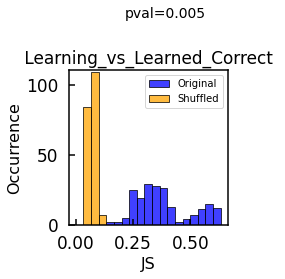

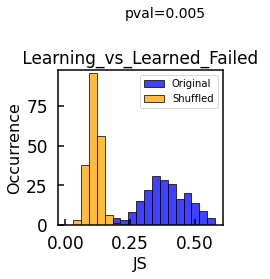

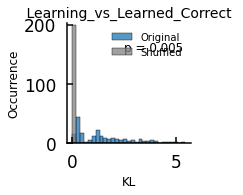

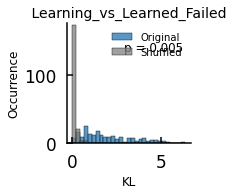

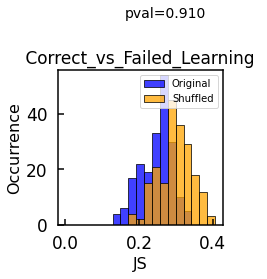

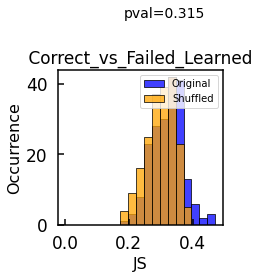

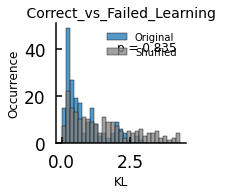

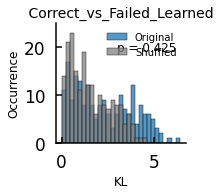

In [53]:
#Visualize sampling cluster distributions
animallist=['478','481','483','485']
#animallist=['478']

import copy
import random
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
cond='sampling'#+animallist[0]
sampling_clusters={}
sampling_clusters_shuffled={}

subsampling_restults={}
subsampling_restults_shuffled={}
# Get cluster distribution  of sampling period
ss_nbr=1
phases={'Learning':0,'Learned':1}
corr_failed={'Failed':0,'Correct':1}
js_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]
                  ,'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
kl_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[],
                  'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
plt.rcParams['axes.titlesize'] = 17  # Set the title font size
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 17  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 17 # You can adjust the font size as needed
plt.rcParams.update({'font.size': 16})

for fol1 in animallist:
        
    #ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)

    ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)



    for ss_nbr in range(len(ss_data_info)):

        for phase in phases.keys():
            phase_nbr=phases[phase]
            for cf in corr_failed.keys():
                corr_failed_nbr=corr_failed[cf]

                org_laels=ss_data_info[ss_nbr]['new_phase_mask']
                shuffled_labels=copy.copy(org_laels)
                random.shuffle(shuffled_labels)# shuffle learning and learned labels


                cond_lbl= [cond_names[cond_name] for cond_name in cond_names if cond in cond_name]
                #sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[ss_nbr]['new_cond_mask']==0)
                sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[0]) | (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[1])


                learned_mask = (org_laels==phase_nbr) 
                correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
                

                mask_sampling_correct_learned=correct_mask & learned_mask #& sampling_mask

                sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
                subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}


                learned_mask_sh = (shuffled_labels==phase_nbr) 

                mask_sampling_correct_learned_sh=correct_mask & learned_mask_sh #& sampling_mask

                sampling_clusters_shuffled[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned_sh]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh], return_counts=True)
                subsampling_restults_shuffled[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}
                


        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)


        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Failed'], subsampling_restults['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Failed'], subsampling_restults_shuffled['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)









p_value_corr_kl_= mot.get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_kl_= mot.get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

p_value_corr_js_= mot.get_pval(js_divergence_ss['Learning_vs_Learned_Correct'],js_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_js_= mot.get_pval(js_divergence_ss['Learning_vs_Learned_Failed'],js_divergence_ss['Learning_vs_Learned_Failed_sh'])



fol1=''

p_value_learning_kl_= mot.get_pval(kl_divergence_ss['Correct_vs_Failed_Learning'],kl_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_kl_= mot.get_pval(kl_divergence_ss['Correct_vs_Failed_Learned'],kl_divergence_ss['Correct_vs_Failed_Learned_sh'])

p_value_learning_js_= mot.get_pval(js_divergence_ss['Correct_vs_Failed_Learning'],js_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_js_= mot.get_pval(js_divergence_ss['Correct_vs_Failed_Learned'],js_divergence_ss['Correct_vs_Failed_Learned_sh'])



  
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=' Learning_vs_Learned_Correct'+' JS',type='Learning_vs_Learned_Correct')
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_failed_js_,name=' Learning_vs_Learned_Failed'+' JS',type='Learning_vs_Learned_Failed')

ax= pf.plot_kl_distributions_ss2(kl_divergence_ss,p_value_corr_kl_,name=' Learning_vs_Learned_Correct'+' KL',type='Learning_vs_Learned_Correct')
hide_spines(ax=ax)
plt.savefig(savefolder+'all KL distance Learning_vs_Learned_Correct.svg',dpi=300)
ax=pf.plot_kl_distributions_ss2(kl_divergence_ss,p_value_failed_kl_,name=' Learning_vs_Learned_Failed'+' KL',type='Learning_vs_Learned_Failed')
hide_spines(ax=ax)
plt.savefig(savefolder+'all KL distance Learning_vs_Learned_Failed.svg',dpi=300)



  
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_learning_js_,name=' Correct_vs_Failed_Learning'+' JS',type='Correct_vs_Failed_Learning')
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_learned_js_,name=' Correct_vs_Failed_Learned'+' JS',type='Correct_vs_Failed_Learned')

ax=pf.plot_kl_distributions_ss2(kl_divergence_ss,p_value_learning_kl_,name=' Correct_vs_Failed_Learning'+' KL',type='Correct_vs_Failed_Learning')
hide_spines(ax=ax)
plt.savefig(savefolder+'all KL distance Correct_vs_Failed_Learning.svg',dpi=300)

ax=pf.plot_kl_distributions_ss2(kl_divergence_ss,p_value_learned_kl_,name=' Correct_vs_Failed_Learned'+' KL',type='Correct_vs_Failed_Learned')
hide_spines(ax=ax)
plt.savefig(savefolder+'all KL distance Correct_vs_Failed_Learned.svg',dpi=300)



In [54]:
savefolder

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results_new/'

In [55]:
# Initialization for running subsampling for entropy
clusteringmethod = 'AHC'
SpeedLimint=0# is not applied anymore

if clusteringmethod =='DB':# clustering algorithgm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)

nrm = np.load('nrm.npy',allow_pickle=True)
min_ratio = 1 # threshold to exclude bad templates
import copy


In [57]:
speed_thr=0
fol1='485'
#sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients'+'Randomized_seqs',allow_pickle=True)
sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_with_PC',allow_pickle=True)

import random
n_subsampling_netropy = 1
Masks = sessinfo_and_mask['Masks']

sess_info = sessinfo_and_mask['sess_info']

# smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
# Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
# Masks['speed']=smooth_speed>speed_thr

# temp_info_subsampling={}
# seq_msk_ing=(np.asanyarray(Masks['bursts_phase'])==0)
# seq_msk_ed=(np.asanyarray(Masks['bursts_phase'])==1)
# seq_len_ing=np.sum((np.asanyarray(Masks['bursts_phase'])==0))# subsampling number
# plot_figure=False# do not show the similarity matrix

# subsampling_restults={'cluster_dist':{}}


# for ss in range(n_subsampling_netropy):# subsampling
#     print(ss)
#     seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
#     bursts=sess_info['bursts']
#     learned_new_phase_mask=np.zeros(np.sum(seq_msk_ed)).astype(bool)

#     seq_learnedg=list(np.asarray(seqs)[seq_msk_ed])# all learned sequences
#     burst_learned=list(np.asarray(bursts)[seq_msk_ed])# all learned bursts
#     # Draw n random indices
#     rnd_indices = random.sample(range(len(seq_learnedg)), seq_len_ing)# random saples withe length of learning data(shorter)
#     learned_new_phase_mask[rnd_indices]=True
#     new_mask=np.hstack((np.ones(np.sum(seq_msk_ing)).astype(bool),learned_new_phase_mask ))# Learnings set to 1, samples learned set to 1

#     #correct_mask_subsampled=seq_msk_ed[rnd_indices]

#     new_cond_mask=np.asarray(Masks['bursts_cond'])[new_mask]
#     new_phase_mask=np.asarray(Masks['bursts_phase'])[new_mask]
#     new_bursts_sess=np.asarray(Masks['bursts_sess'])[new_mask]


#     new_correct_failed_mask=np.asarray(Masks['correct_failed_seqs'])[new_mask]

#     seq_new=np.asarray(seqs)[new_mask]
#     burst_new=np.asarray(bursts)[new_mask]
#     id_peaks_new=np.asarray(sess_info['id_peaks'])[new_mask]
#     #speed_seq_new= np.asarray(sess_info['speed_seq'])[new_mask]
#     speed_seq_new= np.asarray(Masks['speed_seq'])[new_mask]

#     # Use indices to get data from both lists
#     random_seq_ed = [seq_learnedg[i] for i in rnd_indices]# get random subsampling bursts of learned data(longer) with the length of the learning bursts
#     random_burst_ed = [burst_learned[i] for i in rnd_indices]
    
#     # seq_new=list(np.asarray(seqs)[seq_msk_ing])+random_seq_ed# merging learnind and subsampled learned sequences
#     # burst_new=list(np.asarray(bursts)[seq_msk_ing])+random_burst_ed


# # seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# # bursts=sess_info['bursts']

#     #id_peaks=sess_info['id_peaks']
#     #*************** compute clusters from sequences
#     repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seq_new,nrm);
#     ids_clust = mot.cluster(bmat,zmat,clstr_param)
#     temp_info = mot.templates(burst_new,seq_new,nrm,ids_clust,min_ratio = min_ratio)
#     print('cluster', temp_info['exclude'] ,'is removed')
#     #temp_info_org=np.copy(temp_info['template'])
#     temp_info_test = copy.deepcopy(temp_info)
#     temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seq_new,burst_new,plot_figure,min_ratio=.1,z_thr=2.5)
#     #id_peaks=dats['sp_idpeak']
#     #sess_info['ids_clust'] = temp_info_new['ids_clust'][0]



#     temp_info_subsampling[ss]=temp_info_new

#     temp_info_subsampling[ss]['new_cond_mask']=new_cond_mask
#     temp_info_subsampling[ss]['new_phase_mask']=new_phase_mask
#     temp_info_subsampling[ss]['new_correct_failed_mask']=new_correct_failed_mask
#     temp_info_subsampling[ss]['new_id_peaks']=id_peaks_new
#     temp_info_subsampling[ss]['speed_seq_new']=speed_seq_new
#     temp_info_subsampling[ss]['new_bursts_sess']=new_bursts_sess

In [58]:
def generate_hex_colors(n):
    
    color_list = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        if color in color_list:
            continue
        color_list.append(color)

    return color_list



colorlist = generate_hex_colors(np.max(sess_info['ids_clust'])+2)

n_clusters=np.max(sess_info['ids_clust'])+1

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def get_distinguishable_colors(n):
    base_colors = [
        "#FF5733", # Red
        "#33FF57", # Green
        "#3357FF", # Blue
        "#FFD700", # Yellow
        "#FF33FF", # Magenta
        "#33FFFF", # Cyan
        "#800080", # Purple
        "#00FF00", # Lime
        "#FFA500", # Orange
        "#0000FF", # Navy
    ]

    if n <= len(base_colors):
        return base_colors[:n]
    else:
        # Interpolate between the base colors if more colors are needed
        colors = base_colors[:]
        additional_colors_needed = n - len(base_colors)
        for i in range(additional_colors_needed):
            color1 = base_colors[i % len(base_colors)]
            color2 = base_colors[(i + 1) % len(base_colors)]
            new_color = interpolate_colors(color1, color2, 0.5)
            colors.append(new_color)
        return colors

def interpolate_colors(color1, color2, factor):
    c1 = np.array([int(color1[i:i+2], 16) for i in (1, 3, 5)])
    c2 = np.array([int(color2[i:i+2], 16) for i in (1, 3, 5)])
    c_new = (c1 * (1 - factor) + c2 * factor).astype(int)
    return '#' + ''.join(f'{i:02X}' for i in c_new)

# Example usage
n = 15
colors = get_distinguishable_colors(n)
print(colors)
colorlist = get_distinguishable_colors(np.max(sess_info['ids_clust'])+2)


['#FF5733', '#33FF57', '#3357FF', '#FFD700', '#FF33FF', '#33FFFF', '#800080', '#00FF00', '#FFA500', '#0000FF', '#99AB45', '#33ABAB', '#99977F', '#FF857F', '#9999FF']


In [60]:
# Publication-friendly colors
correct_color = '#E69F00'  # Orange
failed_color = '#8C7A1A'   # Olive

In [61]:
def get_indices(key, mapping):
    #cond_number=[2,3] # conditon name (outwards)
    #cond_number=[4,5] # inwards
    #cond_number=[0,1] # sampling
    #cond_number=[6,7] # reward
    #cond_number = [6, 7]
    # Create the full keys for the left and right
    left_key = f"{key}_L"
    right_key = f"{key}_R"
    
    # Retrieve the indices from the mapping
    left_index = mapping.get(left_key, None)
    right_index = mapping.get(right_key, None)
    
    # Return a vector (list) containing both indices
    return [left_index, right_index]


Cond_names_and_numbers={'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7}

In [64]:
Period

'Arena'

In [ ]:
# Here I assign the sequences of Arena and Sleep to clusters
import mtools as mot
nrm = np.load('nrm.npy',allow_pickle=True)
Seq_template_assignment={}
condition ="sampling" # "sampling" #choose wich event do you want to compare with cluster templates(in case of using Task)(sampling, otward, ...)
cond_number = get_indices(condition, Cond_names_and_numbers)
cond_list=['sampling','outward','reward','inward']
#Period='Sleep'
Arena_and_Sleep = {}
Seq_length={}
Temp_length={}

for Period in ['Arena','Sleep','Task']:
    Arena_and_Sleep_animal = {}
    seq_template_assignment={}
    for animal_name in allfolders2:

        # filename = animal_name+'Sesseion_info_All AllNo_chunk_0.5s_transients'
        # data_animal2 = np.load(join(savefolder, filename), allow_pickle=True)# Templates of clusterd data



        #data_animal2 = np.load(savefolder+animal_name+'Sesseion_info'+'_with_PC',allow_pickle=True)

        #Mask_event_condition= np.array(data_animal2['Masks']['bursts_cond'])==Condition_number# if you want to compare task sequences with part do you want to compare(sampling, otward, ...)
        # Create the binary mask
        #data_animal = data_animal2['sess_info']
        data_animal2 =np.load(savefolder+animal_name+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)
        #data_animal = data_animal2['sess_info']

        

        if Period !='Task':
        
            Arena_data = np.load(join(savefolder, animal_name+Period), allow_pickle=True)
        

        if Period =='Task':
                
            Arena_data_cond={}
            seq_template_assignment_cond={}
            for condition in cond_list:
                cond_number = get_indices(condition, Cond_names_and_numbers)

                Mask_event_condition = np.isin( np.array(data_animal2['Masks']['bursts_cond']), cond_number)
                
                    

                seqs=np.array(data_animal2['sess_info']['seqs'])[Mask_event_condition]# get sequences of tasks

                Seq_length[Period+'_'+condition ] = [len(x) for x in seqs]# lengtho of the sequences belong to tasks
                Temp_length[Period+'_'+condition ] = [len(x) for x in data_animal2['sess_info']['template']]# lengtho of Templates belong to tasks

                seqinclusters = {}
                seqinclusters_bool={}
                seqinclusters_sim={}

                matched_seqs=[]


                for itemp, temp in enumerate(data_animal2['sess_info']['template']):
                        
                    chck=mot.check_template(seqs,temp,nrm)
                    matched_seqs.append(np.asarray(seqs)[chck[1].astype(bool)])
                    seqinclusters[itemp]=np.asarray(seqs)[chck[1].astype(bool)]
                    seqinclusters_bool[itemp]=chck[1].astype(bool)
                    seqinclusters_sim[itemp]=chck[0]#.astype(bool)

                Arena_data_cond[condition]=seqinclusters 
                seq_template_assignment_cond[condition]=pf.sequence_template_memebership(seqinclusters_bool,seqinclusters_sim)


            Arena_data['sequences_in_templates']=Arena_data_cond
            seq_template_assignment[animal_name]=seq_template_assignment_cond
            Arena_and_Sleep_animal[animal_name]=Arena_data# data from session_info to show sequence rates


        else:


        
            seqinclusters = {}
            seqinclusters_bool={}
            seqinclusters_sim={}

            matched_seqs=[]
            seqs= Arena_data['sess_info']['seqs']# get sequences of Arean or Sleep
            Seq_length[Period] = [len(x) for x in seqs]# length of sequences within the arena and sleep
            #Temp_length[Period] = [len(x) for x in data_animal2['sess_info']['template']]# lengtho of Templates belong to tasks

            for itemp, temp in enumerate(data_animal2['sess_info']['template']):

                
                chck=mot.check_template(seqs,temp,nrm)
                matched_seqs.append(np.asarray(seqs)[chck[1].astype(bool)])
                seqinclusters[itemp]=np.asarray(seqs)[chck[1].astype(bool)]
                seqinclusters_bool[itemp]=chck[1].astype(bool)
                seqinclusters_sim[itemp]=chck[0]#.astype(bool)
            Arena_data['sequences_in_templates']=    seqinclusters

            seq_template_assignment[animal_name]=pf.sequence_template_memebership(seqinclusters_bool,seqinclusters_sim)
            Arena_and_Sleep_animal[animal_name]=Arena_data# data from session_info to show sequence rates


    Seq_template_assignment[Period]=seq_template_assignment
    Arena_and_Sleep[Period]=Arena_and_Sleep_animal

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results_new/478Sesseion_info_ Allall_days_original_bursts_neworder.5s_transientsArena'

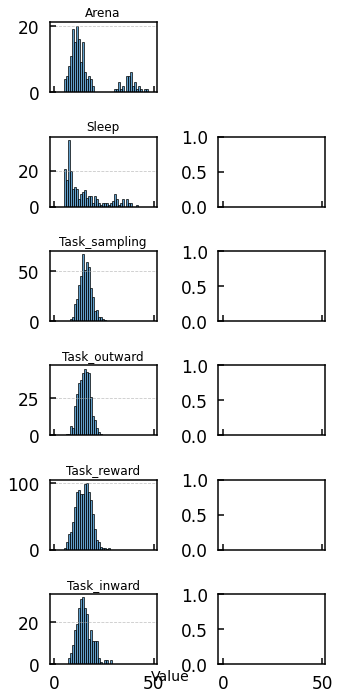

In [ ]:
# Creating subplots for both datasets with independent y-limits
fig, axes = plt.subplots(max(len(Seq_length), len(Temp_length)), 2, figsize=(5, 10), sharex=True)
bins=np.arange(0,50,1)
# Flattening axes array for easier indexing
axes = axes.flatten()

# Plotting seq_length data (left column)
for i, (category, numbers) in enumerate(Seq_length.items()):
    ax = axes[i * 2]  # Left column
    ax.hist(numbers, bins=bins, alpha=0.7, edgecolor='black')
    ax.set_title(category, fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Plotting temp_length data (right column)
# for i, (category, numbers) in enumerate(Temp_length.items()):
#     ax = axes[i * 2 + 5]  # Right column
#     ax.hist(numbers, bins=bins, alpha=0.7, edgecolor='red')
#     ax.set_title(category, fontsize=12)
#     ax.grid(axis='y', linestyle='--', alpha=0.7)

# Leave the upper right plot empty
axes[1].axis('off')  # Turning off the top-right plot

# Adding shared x-label
fig.text(0.5, 0.04, "Value", ha='center', fontsize=14)

# Adjusting layout for better visualization
plt.tight_layout()
plt.show()


In [ ]:
# Restructure data for visulization
final_dict = {}

# Copy 'Arena' and 'Sleep' to the final dictionary
final_dict['Arena'] = Seq_template_assignment['Arena']
final_dict['Sleep'] = Seq_template_assignment['Sleep']

# Extract subkeys from 'Task' and move them as top-level keys
task_subkeys = ['sampling', 'outward', 'reward', 'inward']

for subkey in task_subkeys:
    # Create a new top-level key like 'Task_sampling', 'Task_inward', etc.
    task_key = f'Task_{subkey}'
    
    # Initialize the sub-dictionary for this new key
    final_dict[task_key] = {}
    
    # Loop over the subkeys of 'Task' (478, 481, etc.) and assign corresponding values
    for arena_key in Seq_template_assignment['Task']:
        final_dict[task_key][arena_key] = Seq_template_assignment['Task'][arena_key][subkey]

In [ ]:
phase_for_cluster_assignment='learned'# the sequences are assigned to clusters according to the clusters of the learned data

# Precentage of Arena sequences that are contributing in cluster types
#Period='Task'
SCA_dist={}
SCA_memebership={}
SCA_non_type={}
for Period in final_dict.keys():
    sequnce_cluster_assignment_dist={}# precentage of sequences that belong to clusters with a type label(significant PC/TC)
    sequnce_cluster_assignment_memebership={}
    sequnce_cluster_assignment_dist_non_type={}# precentage of sequences that belong to clusters withouth a type label(not significant PC/TC)

    Seq_assignment= final_dict[Period]
    for animal_name in allfolders2:
        arena_cluster_distributions={}

        seq_template_membership = Seq_assignment[animal_name]
        # if Period=='Task':
        #     seq_template_membership = Seq_assignment[animal_name]['sampling']

       # Convert combined_array to a set for fast lookup
        cluster_type_idx= np.hstack(list(Cluster_type[phase_for_cluster_assignment][animal_name].values()))
        
        for cll_type in Cluster_type[phase_for_cluster_assignment][animal_name]:
            
            for clstr_type in Cluster_type[phase_for_cluster_assignment][animal_name][cll_type]:
            
                arena_cluster_distributions[cll_type+str(clstr_type)]= np.sum(np.asarray(seq_template_membership) ==clstr_type)/len(seq_template_membership)
                

        sequnce_cluster_assignment_dist[animal_name]=arena_cluster_distributions

        sequnce_cluster_assignment_memebership[animal_name]=seq_template_membership


        combined_set = set(cluster_type_idx)

        # Count elements not in combined_array
        not_in_combined = [element for element in seq_template_membership if element not in combined_set]

        # Output the number of elements not in combined_array
        if len(not_in_combined)>0:
            sequnce_cluster_assignment_dist_non_type[animal_name] = len(not_in_combined)/len(seq_template_membership)
    
    SCA_non_type[Period]=sequnce_cluster_assignment_dist_non_type
    SCA_memebership[Period]=sequnce_cluster_assignment_memebership
    SCA_dist[Period]=sequnce_cluster_assignment_dist








In [ ]:
Period='Arena'
#Period='Task_reward'





# Initialize a dictionary to store the summed values
summed_data = {}

# Iterate over each key in the data
for key, subkeys in SCA_dist[Period].items():
    summed_data[key] = {'TC_arm': 0, 'PC_arm': 0, 'TC_stem': 0, 'PC_stem': 0}
    
    for subkey, value in subkeys.items():
        # Determine the type (e.g., TC_arm, PC_arm)
        if 'TC_arm' in subkey:
            summed_data[key]['TC_arm'] += value
        elif 'PC_arm' in subkey:
            summed_data[key]['PC_arm'] += value
        elif 'TC_stem' in subkey:
            summed_data[key]['TC_stem'] += value
        elif 'PC_stem' in subkey:
            summed_data[key]['PC_stem'] += value



# Merge the non_type_data into the existing summed_data
for key in SCA_non_type[Period]:
    if key in summed_data:
        summed_data[key]['non_type'] = SCA_non_type[Period][key]
    else:
        summed_data[key] = {'non_type': SCA_non_type[Period][key]}


# Convert to DataFrame
df = pd.DataFrame.from_dict(summed_data, orient='index')
df.index.name = 'Animal'
df.reset_index(inplace=True)

# Melt DataFrame
df_melted = df.melt(id_vars=['Animal'], var_name='Key', value_name='Value')


In [ ]:
# Using the provided structure to process the full dataset



# Initialize a list to store data for all periods
all_data = []

# Iterate over each period
for period, animals in SCA_dist.items():
    # Initialize a dictionary to store the summed values
    summed_data = {}

    # Iterate over each animal in the period
    for animal, subkeys in animals.items():
        summed_data[animal] = {'TC_arm': 0, 'PC_arm': 0, 'TC_stem': 0, 'PC_stem': 0}

        for subkey, value in subkeys.items():
            if 'TC_arm' in subkey:
                summed_data[animal]['TC_arm'] += value
            elif 'PC_arm' in subkey:
                summed_data[animal]['PC_arm'] += value
            elif 'TC_stem' in subkey:
                summed_data[animal]['TC_stem'] += value
            elif 'PC_stem' in subkey:
                summed_data[animal]['PC_stem'] += value

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(summed_data, orient='index')
    df.index.name = 'Animal'
    df.reset_index(inplace=True)

    # Add a column for the period
    df['Period'] = period

    # Append to the list
    all_data.append(df)

# Concatenate all period DataFrames
final_df = pd.concat(all_data, ignore_index=True)

# Melt DataFrame
df_melted = final_df.melt(id_vars=['Animal', 'Period'], var_name='Key', value_name='Value')



In [ ]:
# Define the target period
Period = 'Arena'  # You can change this to 'Task_reward' or any other period

# Initialize a dictionary to store the summed values
summed_data = {}

# Iterate over each key in the data for the specified period
for key, subkeys in SCA_dist[Period].items():
    summed_data[key] = {'TC_arm': 0, 'PC_arm': 0, 'TC_stem': 0, 'PC_stem': 0}

    for subkey, value in subkeys.items():
        # Determine the type (e.g., TC_arm, PC_arm)
        if 'TC_arm' in subkey:
            summed_data[key]['TC_arm'] += value
        elif 'PC_arm' in subkey:
            summed_data[key]['PC_arm'] += value
        elif 'TC_stem' in subkey:
            summed_data[key]['TC_stem'] += value
        elif 'PC_stem' in subkey:
            summed_data[key]['PC_stem'] += value

# Merge the SCA_non_type data into the existing summed_data
for key in SCA_non_type[Period]:
    if key in summed_data:
        summed_data[key]['non_type'] = SCA_non_type[Period][key]
    else:
        summed_data[key] = {'non_type': SCA_non_type[Period][key]}

# Convert to DataFrame
df = pd.DataFrame.from_dict(summed_data, orient='index')
df.index.name = 'Animal'
df.reset_index(inplace=True)

# Melt DataFrame
df_melted = df.melt(id_vars=['Animal'], var_name='Key', value_name='Value')

# Display the result to the user
##import ace_tools as tools
#tools.display_dataframe_to_user(name=f"Summed Data for {Period}", dataframe=df_melted)


In [ ]:


# Re-running the data aggregation process with the updated SCA_dist and SCA_non_type

# Initialize a list to store dataframes
all_dataframes = []

# Iterate through each period (subkey)
for Period in SCA_dist.keys():
    # Initialize a dictionary to store summed values for the current period
    summed_data = {}

    # Iterate over each key in the data for the current period
    for key, subkeys in SCA_dist[Period].items():
        summed_data[key] = {'TC_arm': 0, 'PC_arm': 0, 'TC_stem': 0, 'PC_stem': 0}

        for subkey, value in subkeys.items():
            # Determine the type (e.g., TC_arm, PC_arm) and sum values accordingly
            if 'TC_arm' in subkey:
                summed_data[key]['TC_arm'] += value
            elif 'PC_arm' in subkey:
                summed_data[key]['PC_arm'] += value
            elif 'TC_stem' in subkey:
                summed_data[key]['TC_stem'] += value
            elif 'PC_stem' in subkey:
                summed_data[key]['PC_stem'] += value

    # Merge the non_type_data into the existing summed_data
    if Period in SCA_non_type:
        for key in SCA_non_type[Period]:
            if key in summed_data:
                summed_data[key]['non_type'] = SCA_non_type[Period][key]
            else:
                summed_data[key] = {'non_type': SCA_non_type[Period][key]}

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(summed_data, orient='index')
    df.index.name = 'Animal'
    df.reset_index(inplace=True)
    df['Period'] = Period

    # Append the dataframe to the list
    all_dataframes.append(df)

# Concatenate all dataframes into one
final_df = pd.concat(all_dataframes, ignore_index=True)

# Melt the final dataframe
final_df_melted = final_df.melt(id_vars=['Animal', 'Period'], var_name='Key', value_name='Value')



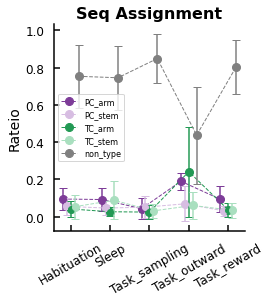

In [ ]:
# Define colors for the corresponding categories
categories = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm', 'non_type']
colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954', 'gray']
color_mapping = {
    'PC_stem': '#D7BDE2',
    'PC_arm': '#7D3C98',
    'TC_stem': '#A9DFBF',
    'TC_arm': '#229954',
    'non_type': 'gray'
}
# Filter data to exclude 'Task_inward' period
filtered_data = final_df_melted[final_df_melted['Key'].isin(categories) & (final_df_melted['Period'] != 'Task_inward')]

# Group the data by 'Period' and 'Key' and calculate the mean and standard deviation
mean_std_values = filtered_data.groupby(['Period', 'Key'])['Value'].agg(['mean', 'std']).unstack()


# Plotting with jitter to avoid overlap
plt.figure(figsize=(4, 4.5))  # Reduced plot size

# Define a jitter array to slightly offset the points on the x-axis
jitter = np.linspace(-0.2, 0.2, len(mean_std_values['mean'].columns))

# Define new order
new_order = ['Habituation', 'Sleep', 'Task_sampling', 'Task_outward', 'Task_reward']

# Map the rows to the new order (replace 'Habituation' as needed if no match)
mean_std_values.index = ['Habituation', 'Sleep', 'Task_outward', 'Task_reward', 'Task_sampling']
mean_std_values_reorder = mean_std_values.reindex(new_order)

# Plot each type with specified colors, dashed lines, and jittered points
for i, column in enumerate(mean_std_values_reorder['mean'].columns):
    plt.plot(
        np.arange(len(mean_std_values_reorder.index)) + jitter[i],
        mean_std_values_reorder['mean'][column],
        marker='o',markersize=8,
        alpha=1,  # Transparency for the points
        label=column,
        color=color_mapping[column],
        linestyle='dashed',  # Dashed lines
        linewidth=1 # Slightly thinner lines
    )
    # Add error bars for standard deviation at intersection points
    plt.errorbar(
        np.arange(len(mean_std_values_reorder.index)) + jitter[i],
        mean_std_values_reorder['mean'][column],
        yerr=mean_std_values_reorder['std'][column],
        fmt='o',
        color=color_mapping[column],
        capsize=4
    )

# Customize the plot to make it publication-ready
plt.title('Seq Assignment', fontsize=16, fontweight='bold')
plt.ylabel('Rateio', fontsize=14)
plt.xticks(np.arange(len(mean_std_values_reorder.index)), mean_std_values_reorder.index, rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=8)

# Remove gridlines
plt.grid(False)
hide_spines()
plt.tight_layout()
#plt.savefig(savefolder+'Seq_Assignment_merged.svg')
plt.show()


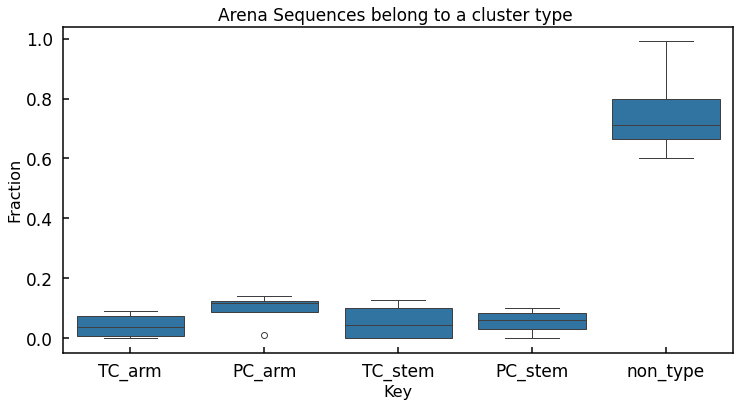

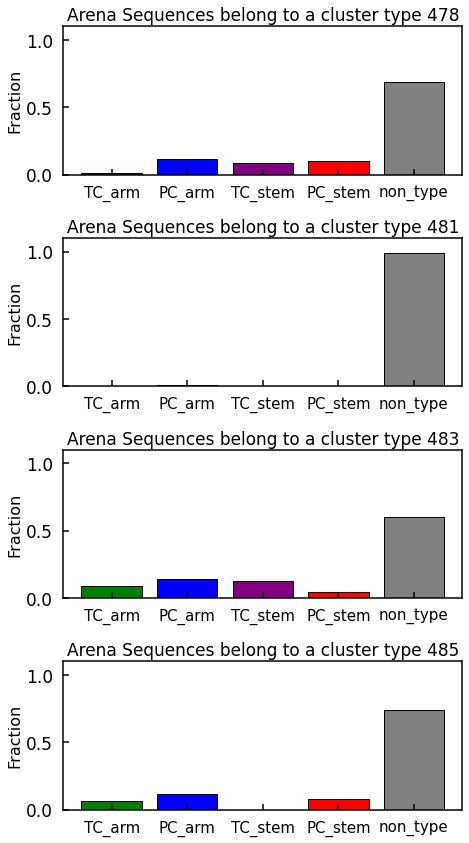

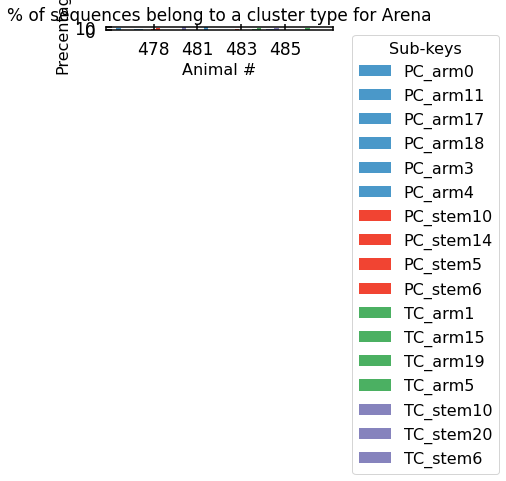

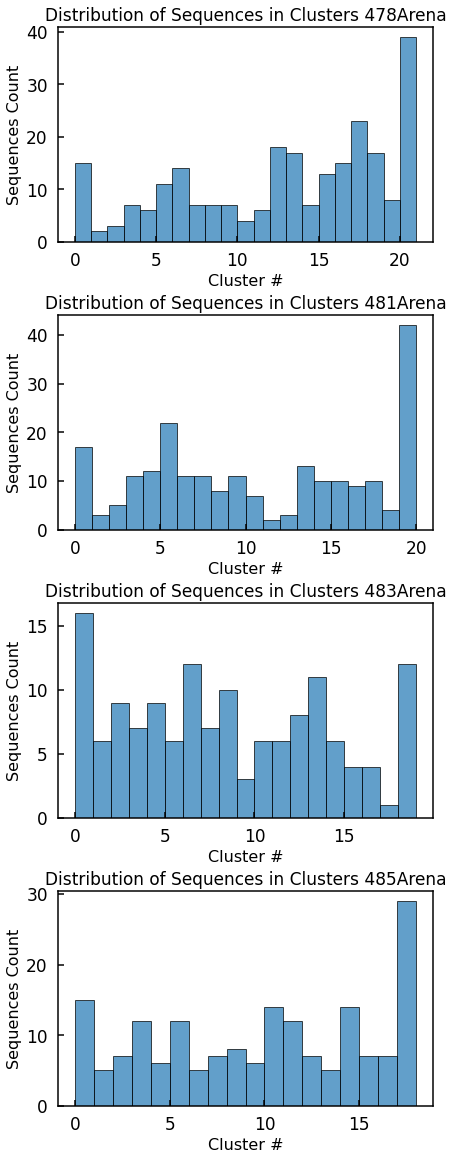

In [ ]:

###########Visualize####################################


Period='Arena'
#Period='Task_reward'





# Initialize a dictionary to store the summed values
summed_data = {}

# Iterate over each key in the data
for key, subkeys in SCA_dist[Period].items():
    summed_data[key] = {'TC_arm': 0, 'PC_arm': 0, 'TC_stem': 0, 'PC_stem': 0}
    
    for subkey, value in subkeys.items():
        # Determine the type (e.g., TC_arm, PC_arm)
        if 'TC_arm' in subkey:
            summed_data[key]['TC_arm'] += value
        elif 'PC_arm' in subkey:
            summed_data[key]['PC_arm'] += value
        elif 'TC_stem' in subkey:
            summed_data[key]['TC_stem'] += value
        elif 'PC_stem' in subkey:
            summed_data[key]['PC_stem'] += value



# Merge the non_type_data into the existing summed_data
for key in SCA_non_type[Period]:
    if key in summed_data:
        summed_data[key]['non_type'] = SCA_non_type[Period][key]
    else:
        summed_data[key] = {'non_type': SCA_non_type[Period][key]}


# Convert to DataFrame
df = pd.DataFrame.from_dict(summed_data, orient='index')
df.index.name = 'Animal'
df.reset_index(inplace=True)

# Melt DataFrame
df_melted = df.melt(id_vars=['Animal'], var_name='Key', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Key', y='Value', data=df_melted)
plt.title(Period +f' Sequences belong to a cluster type ')
#plt.xlabel('Key')
plt.ylabel('Fraction')
plt.show()



# Prepare the data for plotting
categories = ['TC_arm', 'PC_arm', 'TC_stem', 'PC_stem', 'non_type']
keys = list(summed_data.keys())
values = {category: [summed_data[key].get(category, 0) for key in keys] for category in categories}

# Create subplots
fig, axs = plt.subplots(len(keys), 1, figsize=(8, 12))

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    x_positions = np.arange(len(categories))
    axs[i].bar(x_positions, [values[category][i] for category in categories], color=['green', 'blue', 'purple', 'red', 'gray'],edgecolor='k')
    if Period=='Task':
        axs[i].set_title(f'Sequences belong to a cluster type for  {key} '+Period+'_'+condition)
    else:
        #axs[i].set_title(f'Sequences belong to a cluster type for  {key} '+Period)
        axs[i].set_title(Period +f' Sequences belong to a cluster type {key}')


    axs[i].set_ylabel('Fraction')
    axs[i].set_xticks(x_positions)
    axs[i].set_xticklabels(categories,fontsize=15)
    axs[i].set_ylim([0,1.1])

# Add a common x-axis label for all subplots
#fig.text(0.5, 0.04, 'Categories', ha='center')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()



# Prepare the data for plotting
keys = list(SCA_dist[Period].keys())
all_subkeys = set(subkey for value in SCA_dist[Period].values() for subkey in value)
all_subkeys = sorted(all_subkeys)

# Define colormaps for each category
color_map = {
    'PC_arm': 'Blues',
    'TC_arm': 'Greens',
    'PC_stem': 'Reds',
    'TC_stem': 'Purples'
}

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

bar_width = 0.1
index = np.arange(len(keys))

for i, subkey in enumerate(all_subkeys):
    # Extract the category part, ensuring it matches the keys in color_map
    if 'arm' in subkey:
        category = subkey.split('_')[0] + '_arm'
    elif 'stem' in subkey:
        category = subkey.split('_')[0] + '_stem'
    
    color = plt.get_cmap(color_map[category])(0.6)  # Get color from the respective colormap
    values = [SCA_dist[Period][key].get(subkey, 0) for key in keys]
    ax.bar(index + i * bar_width, 100*np.asarray(values), bar_width, label=subkey, color=color)

# Adding labels and title
ax.set_xlabel('Animal #')
ax.set_ylabel('Precentage')
ax.set_title('% of sequences belong to a cluster type for '+Period)
if Period=='Task':
    ax.set_title('% of sequences belong to a cluster type for '+Period+condition)

ax.set_xticks(index + bar_width * (len(all_subkeys) - 1) / 2)
ax.set_xticklabels(keys)
ax.legend(title='Sub-keys', bbox_to_anchor=(1.05, 1), loc='upper left')


# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()



# Determine the number of subplots needed
num_plots = len([key for key in SCA_memebership[Period].keys() if SCA_memebership[Period][key]])

# Create subplots
fig, axs = plt.subplots(num_plots, 1, figsize=(6, 4 * num_plots), constrained_layout=True)

# Plot each key in a separate subplot
for i, (key, values) in enumerate(SCA_memebership[Period].items()):
    if values:  # Only create a subplot if there are values
        axs[i].hist(values, bins=np.max(values), alpha=0.7, edgecolor='black')
        axs[i].set_title(f'Distribution of Sequences in Clusters {key}'+Period)

        axs[i].set_xlabel('Cluster #')
        axs[i].set_ylabel('Sequences Count')

# Show the plot
plt.show()

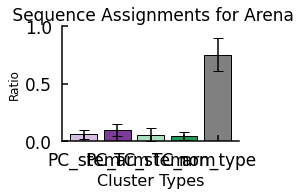

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for averaging
#categories = ['TC_arm', 'PC_arm', 'TC_stem', 'PC_stem', 'non_type']
#regions = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm']
categories = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm', 'non_type']

colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954','gray']
# Initialize structures to store aggregated data
aggregated_values = {category: [] for category in categories}

# Collect data for each category across animals
for key in summed_data:
    for category in categories:
        aggregated_values[category].append(summed_data[key].get(category, 0))

# Compute averages and standard deviations
averages = {category: np.mean(aggregated_values[category]) for category in categories}
std_devs = {category: np.std(aggregated_values[category]) for category in categories}

# Prepare data for plotting
x_positions = np.arange(len(categories))
mean_values = [averages[category] for category in categories]
std_values = [std_devs[category] for category in categories]

# Plot the data
fig, ax = plt.subplots(figsize=(4 ,3))

ax.bar(x_positions, mean_values, yerr=std_values, capsize=5, color=colors,edgecolor='k',label=categories)
ax.set_title(f' Sequence Assignments for {Period}')
#ax.set_ylabel('Percentage')
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.set_ylim([0, 1])

# Add labels for clarity
ax.set_xlabel('Cluster Types')
ax.set_ylabel('Ratio',fontsize=12)
hide_spines(ax)
plt.tight_layout()
#plt.legend()
plt.savefig(savefolder+'Sequence_assignment'+Period+'new.svg', format='svg',dpi=300)

plt.show()


In [ ]:
# to Merge rates of all animals

rate_all={'correct_and_failed':[],'correct':[],'failed':[],'sleep':[],'arena':[],}

for fol in ['478','481','483','485']:

    #savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
    #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
    #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
    #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
    #fol='481'
    phase='all'
    filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

    #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)






    fr_all_tasks= data_all_tasks['sess_info']['fr']
    mask_all_fr= np.asarray(data_all_tasks['Masks']['correct_failed_fr'])




    rate_all['correct'].extend(np.asarray(fr_all_tasks)[mask_all_fr.astype(bool)])
    rate_all['failed'].extend(np.asarray(fr_all_tasks)[~mask_all_fr.astype(bool)])
    rate_all['correct_and_failed'].extend(np.asarray(fr_all_tasks))


    rate_all['arena'].extend(Arena_and_Sleep['Arena'][fol]['sess_info']['fr'])
    rate_all['sleep'].extend(Arena_and_Sleep['Sleep'][fol]['sess_info']['fr'])

In [ ]:
# Adjusting the significance line positions for sleep and arena comparisons
def add_significance_lines(ax, p_values, order, base_y_offset=0.02, increment_y_offset=0.02, line_offset=0.01):
    y_max = ax.get_ylim()[1]
    current_y_offset = base_y_offset

    for pair, p_value in p_values.items():
        if p_value < 0.05:
            # Special handling for "correct_and_failed"
            if pair[0] == 'correct_and_failed':
                x1 = order.index('correct')
                x2 = order.index('failed')
            else:
                x1 = order.index(pair[0])
                x2 = order.index(pair[1])
            
            # Adjust x positions for sleep and arena based on order
            if pair[1] == 'sleep':
                x2 = order.index('sleep')
            if pair[1] == 'arena':
                x2 = order.index('arena')
            
            # Calculate dynamic y position
            y = y_max + current_y_offset
            current_y_offset += increment_y_offset
            
            # Add the stars
            if p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            
            # Plot the significance stars
            ax.text((x1 + x2) * 0.5, y, significance, ha='center', va='bottom', color='k', fontsize=10)
            
            # Plot horizontal line
            ax.plot([x1, x1, x2, x2], [y - line_offset, y, y, y - line_offset], lw=.5, color='k')

# # Redraw the plot with corrected x positions for significance lines
# plt.figure(figsize=(6, 4))
# ax = sns.boxplot(
#     data=[Sequence_rate_all_data[key] for key in order],
#     palette="Set3",
#     width=0.6,
#     showmeans=False,
#     meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
# )

# # Hide unnecessary spines
# for spine in ['top', 'right']:
#     ax.spines[spine].set_visible(False)

# # Apply the updated function to add significance lines
# add_significance_lines(ax, adjusted_p_values, order)

# # Update x-axis labels
# plt.xticks(range(len(order)), [x.capitalize() for x in order], fontsize=12)

# # Label and title
# plt.ylabel('Sequence Rate (Hz)', fontsize=12)
# plt.title('Sequence Rate Comparison', fontsize=14)

# # Save and show the plot
# plt.tight_layout()
# plt.show()


{('correct', 'failed'): 0.004271706622558129, ('correct_and_failed', 'sleep'): 9.340808401465745e-130, ('correct_and_failed', 'arena'): 8.011762356829622e-05}


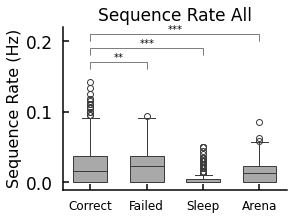

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
plot_all_rates=True
if plot_all_rates == True:

    Sequence_rate_all_data=rate_all #  for merged data
    fol='All'
# Kruskal-Wallis H test across all groups
#H, p = stats.kruskal(Sequence_rate_all_data['correct'], Sequence_rate_all_data['failed'], Sequence_rate_all_data['sleep'], Sequence_rate_all_data['arena'])
#print(f"Kruskal-Wallis H-test: H = {H}, p = {p}")

# Pairwise comparisons with Mann-Whitney U test (for post-hoc analysis)
#pairs = list(combinations(Sequence_rate_all_data.keys(), 2))

pairs= [('correct', 'failed'),
 ('correct_and_failed', 'sleep'),
 ('correct_and_failed', 'arena'),]
p_values = {}
for pair in pairs:
    _, p_value = stats.mannwhitneyu(Sequence_rate_all_data[pair[0]], Sequence_rate_all_data[pair[1]], alternative='two-sided')
    p_values[pair] = p_value

# Bonferroni correction for multiple comparisons
adjusted_p_values = {pair: min(p_val * len(pairs), 1.0) for pair, p_val in p_values.items()}
print(adjusted_p_values)  # Print adjusted p-values for verification



# Correct the order of the data
order = ['correct', 'failed', 'sleep', 'arena']

# Visualization with the correct order
plt.figure(figsize=(4,3))
#ax = sns.boxplot(data=[Sequence_rate_all_data[key] for key in order], palette="Set3")
#sns.swarmplot(data=[Sequence_rate_all_data[key] for key in order], color=".25")
# Boxplot
ax = sns.boxplot(
    data=[Sequence_rate_all_data[key] for key in order],
    color="#A9A9A9",
    width=0.6,
    showmeans=False,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
)

hide_spines(ax)
# Apply the significance lines and stars with the correct order
add_significance_lines(ax, p_values,  order)
plt.xticks(range(len(order)), [x.capitalize() for x in order], fontsize=12)

#plt.xticks(range(len(order)), order)
plt.ylabel('Sequence Rate (Hz)')
plt.title('Sequence Rate '+ fol)
plt.savefig(savefolder+fol+'_sequence_rate.svg', format='svg', dpi=300)  # Vector format

plt.show()

                                  stat        p_value  n_group1  n_group2  \
correct vs failed            3461962.5   1.423902e-03      4758      1536   
correct_and_failed vs sleep  4974538.5  3.113603e-130      6294      1096   
correct_and_failed vs arena  1546011.0   2.670587e-05      6294       440   

                             adjusted_p_value  
correct vs failed                4.271707e-03  
correct_and_failed vs sleep     9.340808e-130  
correct_and_failed vs arena      8.011762e-05  


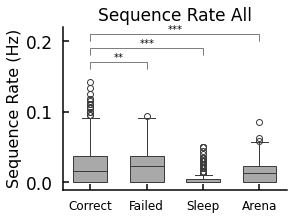

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

plot_all_rates = True
if plot_all_rates:

    Sequence_rate_all_data = rate_all  # For merged data
    fol = 'All'

# Define pairs for comparisons
pairs = [
    ('correct', 'failed'),
    ('correct_and_failed', 'sleep'),
    ('correct_and_failed', 'arena'),
]

# Dictionary to store results
results = {}

# Perform pairwise comparisons
for pair in pairs:
    data1 = Sequence_rate_all_data[pair[0]]
    data2 = Sequence_rate_all_data[pair[1]]

    # Perform Mann-Whitney U test
    if len(data1) > 0 and len(data2) > 0:
        stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    else:
        stat, p_value = np.nan, np.nan

    # Store results
    results[pair] = {
        'stat': stat,
        'p_value': p_value,
        'n_group1': len(data1),
        'n_group2': len(data2),
    }

# Adjust p-values using Bonferroni correction
for pair in results:
    results[pair]['adjusted_p_value'] = min(results[pair]['p_value'] * len(pairs), 1.0)

# Convert results into a DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index = [f"{pair[0]} vs {pair[1]}" for pair in results.keys()]  # Add readable labels

# Print or save the results table
print(results_df)

# Optional: Save the table to a CSV file
results_df.to_csv(f"{fol}_pairwise_comparisons.csv", index=True)

# Correct the order of the data
order = ['correct', 'failed', 'sleep', 'arena']
# Visualization with the correct order
plt.figure(figsize=(4,3))
#ax = sns.boxplot(data=[Sequence_rate_all_data[key] for key in order], palette="Set3")
#sns.swarmplot(data=[Sequence_rate_all_data[key] for key in order], color=".25")
# Boxplot
ax = sns.boxplot(
    data=[Sequence_rate_all_data[key] for key in order],
    color="#A9A9A9",
    width=0.6,
    showmeans=False,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
)

hide_spines(ax)
# Apply the significance lines and stars with the correct order
add_significance_lines(ax, p_values,  order)
plt.xticks(range(len(order)), [x.capitalize() for x in order], fontsize=12)

#plt.xticks(range(len(order)), order)
plt.ylabel('Sequence Rate (Hz)')
plt.title('Sequence Rate '+ fol)
plt.savefig(savefolder+fol+'_sequence_rate.svg', format='svg', dpi=300)  # Vector format

plt.show()

In [ ]:
def interpolate_colors(color1, color2, factor):
    c1 = np.array([int(color1[i:i+2], 16) for i in (1, 3, 5)])
    c2 = np.array([int(color2[i:i+2], 16) for i in (1, 3, 5)])
    c_new = (c1 * (1 - factor) + c2 * factor).astype(int)
    return '#' + ''.join(f'{i:02X}' for i in c_new)


def get_distinguishable_colors(n):
    base_colors = [
        "#FF5733", # Red
        "#33FF57", # Green
        "#3357FF", # Blue
        "#FFD700", # Yellow
        "#FF33FF", # Magenta
        "#33FFFF", # Cyan
        "#800080", # Purple
        "#00FF00", # Lime
        "#FFA500", # Orange
        "#0000FF", # Navy
    ]

    if n <= len(base_colors):
        return base_colors[:n]
    else:
        # Interpolate between the base colors if more colors are needed
        colors = base_colors[:]
        additional_colors_needed = n - len(base_colors)
        for i in range(additional_colors_needed):
            color1 = base_colors[i % len(base_colors)]
            color2 = base_colors[(i + 1) % len(base_colors)]
            new_color = interpolate_colors(color1, color2, 0.5)
            colors.append(new_color)
        return colors

c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools.py:487: RuntimeWarning: invalid value encountered in true_divide
  cofseq=(itax@vec.transpose())/nvec
c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools.py:697: RuntimeWarning: invalid value encountered in true_divide
  cofseq.append((itax@vec.transpose())/nvec/fs)


0 (109,)
1 (109,)
2 (109,)


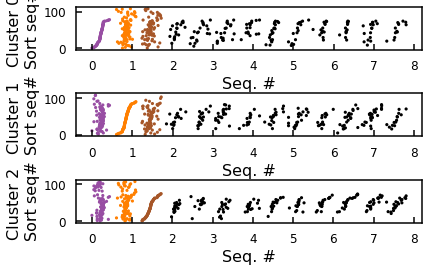

In [ ]:

import mtools as mot

seqs=list(seqs)
fs=20# sampling freq
temp_info=sessinfo_and_mask['sess_info']
colorlist = get_distinguishable_colors(np.max(temp_info['ids_clust'])+2)



import copy
bursts=temp_info['bursts']
seqAll=copy.copy(seqs)
for nc in range(len(temp_info['template'])):    
    seqAll.append(temp_info['template'][nc])
    
#G, pos = mot.graph(seqAll,nrm,temp_info_new)
mot.plot_seqs(temp_info,bursts,fs)
#plt.savefig(savefolder+'sorted_sample_sequence2.svg', format='svg',dpi=300)
plt.show(block=0)

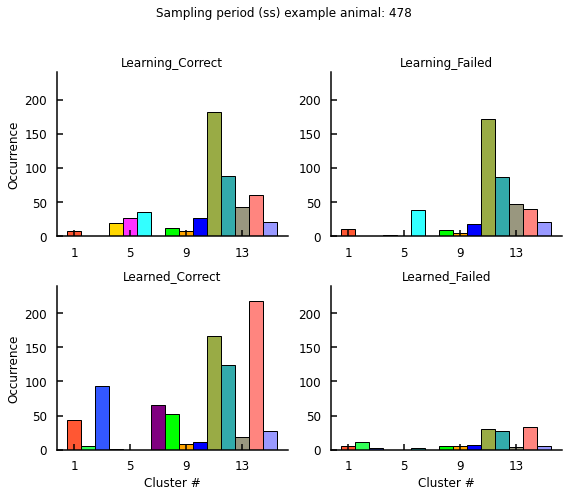

In [ ]:
ss=8

# Load entropy of subsampling 

all_entropies_ss={}
place_cell_name='All'
cell_types='All'
burst_len='0.5s'

descriotor='No_chunk_'+burst_len+'_transients'#+'Randomized_seqs'
for fol1 in ['478']:

    temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)







sampling_clusters={}
subsampling_restults={}
# Get cluster distribution  of sampling period
ss_nbr=ss
phases={'Learning':0,'Learned':1}
corr_failed={'Correct':1,'Failed':0,}

for phase in phases.keys():
    phase_nbr=phases[phase]
    for cf in corr_failed.keys():
        corr_failed_nbr=corr_failed[cf]


        sampling_mask = (temp_info_subsampling[ss_nbr]['new_cond_mask']==1) | (temp_info_subsampling[ss_nbr]['new_cond_mask']==0)
        learned_mask = (temp_info_subsampling[ss_nbr]['new_phase_mask']==phase_nbr) 
        correct_mask = (temp_info_subsampling[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
        

        mask_sampling_correct_learned=correct_mask & learned_mask #& sampling_mask

        sampling_clusters[phase+'_'+cf]=np.asarray(temp_info_subsampling[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

        labels, counts = np.unique(temp_info_subsampling[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
        subsampling_restults[phase+'_'+cf]= {'seq_len':len(temp_info_subsampling[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                    'cluster_number': labels, 'clsuster_counts':counts}

# Define parameters and set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
axes = axes.flatten()  # Flatten for easy iteration

# Determine maximum cluster number for consistent binning
max_clusters = []
for key, values in sampling_clusters.items():
    max_clusters.append(np.max(subsampling_restults[key]['cluster_number']))
max_cluster_nbr = np.max(max_clusters)

# Create bins as integers from 0 to max_cluster_nbr + 1
bins = np.arange(0, max_cluster_nbr + 2)  # Ensures each integer has its own bin

# Create a color mapping for each cluster ID
color_mapping = {cluster_id: colorlist[cluster_id % len(colorlist)] for cluster_id in range(max_cluster_nbr + 1)}

# Determine maximum y-limit across all subplots
max_count = 0
for key, values in sampling_clusters.items():
    counts, _ = np.histogram(values, bins=bins)
    max_count = max(max_count, counts.max())

# Loop through each axis and plot the histograms with integer bins and colors
for i, (ax, (key, values)) in enumerate(zip(axes, sampling_clusters.items())):
    color = correct_color if 'Correct' in key else failed_color

    # Plot histogram with integer bins
    counts, bins, patches = ax.hist(values,density=False, bins=bins, edgecolor='k')

    # Apply specific color to each bin based on cluster ID
    for patch, bin_num in zip(patches, range(len(patches))):
        cluster_id = bin_num  # Use bin number as cluster ID
        if cluster_id in color_mapping:
            patch.set_facecolor(color_mapping[cluster_id])  # Set color from color mapping

    # Set x-ticks at integer bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.set_xticks(bin_centers[::4])
    ax.set_xticklabels([str(int(center+1)) for center in bin_centers[::4]])

    # Apply uniform y-limit based on the maximum count
    ax.set_ylim(0, max_count * 1.1)  # Add 10% padding to the y-limit
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label "Cluster #" on x-axis only for the bottom row
    if i >= 2:  # Bottom row
        ax.set_xlabel('Cluster #', fontsize=12)

    # Label "Occurrence" on every other plot for y-axis
    if i % 2 == 0:
        ax.set_ylabel('Occurrence', fontsize=12)
    
    # Title for each subplot
    ax.set_title(key)

# Global title and layout adjustment
plt.suptitle('Sampling period (ss) example animal: ' + fol1)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for suptitle
#plt.savefig(savefolder + 'sample_distributions.svg', dpi=300)
plt.show()

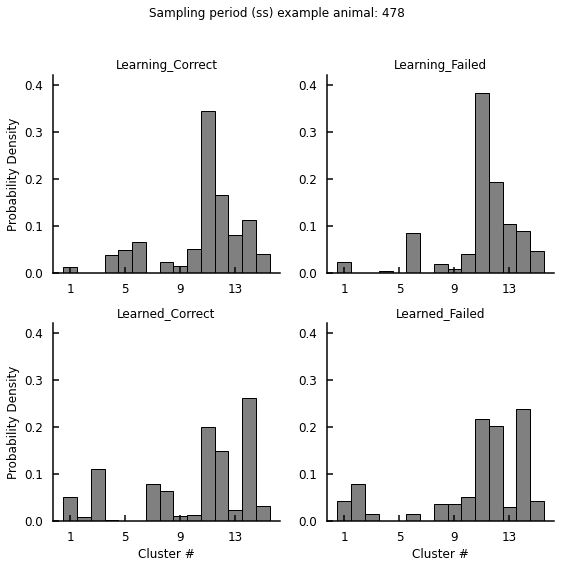

In [ ]:
# Define parameters and set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.flatten()  # Flatten for easy iteration

# Determine maximum cluster number for consistent binning
max_clusters = []
for key, values in sampling_clusters.items():
    max_clusters.append(np.max(subsampling_restults[key]['cluster_number']))
max_cluster_nbr = np.max(max_clusters)

# Create bins as integers from 0 to max_cluster_nbr + 1
bins = np.arange(0, max_cluster_nbr + 2)  # Ensures each integer has its own bin

# Determine maximum PDF value across all subplots for consistent y-limits
max_pdf = 0
for key, values in sampling_clusters.items():
    counts, _ = np.histogram(values, bins=bins)
    bin_width = bins[1] - bins[0]
    pdf = counts / (len(values) * bin_width)  # Normalize to get PDF
    max_pdf = max(max_pdf, pdf.max())

# Neutral color for all bars
neutral_color = "gray"

# Loop through each axis and plot the PDFs
for i, (ax, (key, values)) in enumerate(zip(axes, sampling_clusters.items())):
    # Compute histogram counts and normalize to get PDF
    counts, bins = np.histogram(values, bins=bins)
    bin_width = bins[1] - bins[0]
    pdf = counts / (len(values) * bin_width)  # Manual PDF calculation

    # Plot the PDF as a bar chart with a neutral color
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, pdf, width=bin_width, edgecolor='k', color=neutral_color)

    # Set x-ticks at integer bin centers
    ax.set_xticks(bin_centers[::4])
    ax.set_xticklabels([str(int(center + 1)) for center in bin_centers[::4]])

    # Apply uniform y-limit based on the maximum PDF value
    ax.set_ylim(0, max_pdf * 1.1)  # Add 10% padding to the y-limit
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label "Cluster #" on x-axis only for the bottom row
    if i >= 2:  # Bottom row
        ax.set_xlabel('Cluster #', fontsize=12)

    # Label "Probability Density" on every other plot for y-axis
    if i % 2 == 0:
        ax.set_ylabel('Probability Density', fontsize=12)
    
    # Title for each subplot
    ax.set_title(key)

plt.tight_layout()

# Global title and layout adjustment
plt.suptitle('Sampling period (ss) example animal: ' + fol1)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for suptitle
plt.savefig(savefolder + 'sample_distributions1_pdf.svg', dpi=300)
plt.show()